# Archaic admixture in swept and non-swept haplotypes and regions

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

numpy.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}


def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [4]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Import variables global to the entire analysis:

In [5]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [6]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [7]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

## Load meta data

In [8]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

## Sweep and admixture data

In [9]:
admix_windows_chrX = pandas.read_hdf(results_dir / 'male_x_admix_windows.hdf')
admix_windows_chrX.head()

chrom            name   start     end  nr_admix_tracts  mean_post_prob  \
0     X  B_Australian-4       0  100000                0             NaN   
1     X  B_Australian-4  100000  200000                0             NaN   
2     X  B_Australian-4  200000  300000                0             NaN   
3     X  B_Australian-4  300000  400000                0             NaN   
4     X  B_Australian-4  400000  500000                0             NaN   

   archaic_snps  denisova_snps  tot_admix_len  altai_snps  vindija_snps  \
0           NaN            NaN              0         NaN           NaN   
1           NaN            NaN              0         NaN           NaN   
2           NaN            NaN              0         NaN           NaN   
3           0.0            0.0              0         0.0           0.0   
4           0.0            0.0              0         0.0           0.0   

   admix_prop  level_1  bases_analyzed  
0         NaN        0            1337  
1         NaN        1            5045  
2         NaN        2            9875  
3         0.0        3           26649  
4         0.0        4           22968

In [10]:
admix_windows_chrX_full = pandas.read_hdf(results_dir / 'male_x_admix_windows_full.hdf')
admix_windows_chrX_full.head()

chrom            name   start     end  nr_admix_tracts  tot_admix_len  \
0     X  B_Australian-4       0  100000                0              0   
1     X  B_Australian-4  100000  200000                0              0   
2     X  B_Australian-4  200000  300000                0              0   
3     X  B_Australian-4  300000  400000                0              0   
4     X  B_Australian-4  400000  500000                0              0   

   mean_post_prob  admix_prop  level_1  bases_analyzed  
0             NaN         NaN        0            1602  
1             NaN         NaN        1            6492  
2             NaN         NaN        2           14598  
3             NaN         0.0        3           37371  
4             NaN         0.0        4           31532

In [11]:
sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')

# analysis without repeats
merged_data = (sweep_data.merge(admix_windows_chrX, how='left',
                                right_on=['name', 'start', 'end'], 
                                left_on=['indiv_1', 'start', 'end'])
               .loc[lambda df: df.not_missing == True] # only windows where enough individuals are called
              )

# analysis including repeats
merged_data_full = (sweep_data.merge(admix_windows_chrX_full, how='left',
                                right_on=['name', 'start', 'end'], 
                                left_on=['indiv_1', 'start', 'end'])
               .loc[lambda df: df.not_missing == True] # only windows where enough individuals are called
              )

In [74]:
df = merged_data[['name', 'start', 'admix_prop']].merge(merged_data_full[['name', 'start', 'admix_prop']], 
                                                   on=['name', 'start'], how='outer')

In [80]:
((~df.admix_prop_x.isnull() & ~df.admix_prop_y.isnull()).sum(), 
 (df.admix_prop_x.isnull() & ~df.admix_prop_y.isnull()).sum())

(169377, 23766)

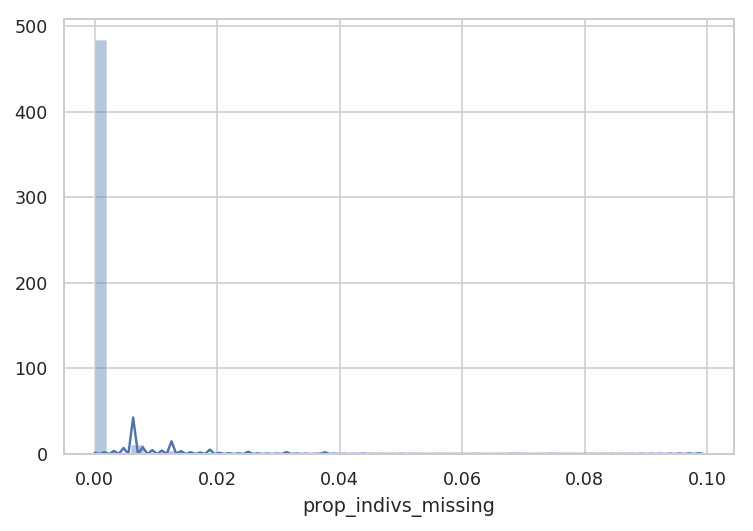

In [12]:
g = sns.distplot(merged_data.prop_indivs_missing)

## Global admixture proportions

In [13]:
merged_data.loc[lambda df: df.region_1 != 'Africa', 'admix_prop'].mean()

0.0080504436847978183

In [14]:
merged_data.groupby('region_1')['admix_prop'].mean()

region_1
Africa                     NaN
WestEurasia           0.006498
SouthAsia             0.008298
CentralAsiaSiberia    0.004931
Oceania               0.014618
EastAsia              0.008455
America               0.005812
Name: admix_prop, dtype: float64

In [15]:
merged_data.head()

indiv_1    start      end       pop_1 region_label_1  region_id_1  \
27  B_Australian-4  2700000  2800000  Australian        Oceania            4   
28  B_Australian-4  2800000  2900000  Australian        Oceania            4   
29  B_Australian-4  2900000  3000000  Australian        Oceania            4   
30  B_Australian-4  3000000  3100000  Australian        Oceania            4   
31  B_Australian-4  3100000  3200000  Australian        Oceania            4   

   region_1  mean_dist  mean_dist_af  mean_dist_to_africans       ...        \
27  Oceania   0.001051      0.001051               0.001735       ...         
28  Oceania   0.000633      0.000623               0.001109       ...         
29  Oceania   0.000377      0.000318               0.000844       ...         
30  Oceania   0.001087      0.001087               0.001078       ...         
31  Oceania   0.001212      0.001205               0.001544       ...         

    nr_admix_tracts  mean_post_prob  archaic_snps  denisova_snps  \
27              0.0             NaN           0.0            0.0   
28              0.0             NaN           0.0            0.0   
29              0.0             NaN           0.0            0.0   
30              0.0             NaN           0.0            0.0   
31              0.0             NaN           0.0            0.0   

    tot_admix_len  altai_snps  vindija_snps  admix_prop  level_1  \
27            0.0         0.0           0.0         0.0     27.0   
28            0.0         0.0           0.0         0.0     28.0   
29            0.0         0.0           0.0         0.0     29.0   
30            0.0         0.0           0.0         0.0     30.0   
31            0.0         0.0           0.0         0.0     31.0   

    bases_analyzed  
27         31236.0  
28         27918.0  
29         31151.0  
30         41200.0  
31         45155.0  

[5 rows x 47 columns]

## Admixture segments across the X chromosome

In [16]:
extended_peak_regions_10 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_10%.hdf')
extended_peak_regions_75 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_75%.hdf')
extended_peak_regions_90 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_90%.hdf')
human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')
ampliconic_regions = pandas.read_hdf(results_dir / 'ampliconic_regions.hdf')


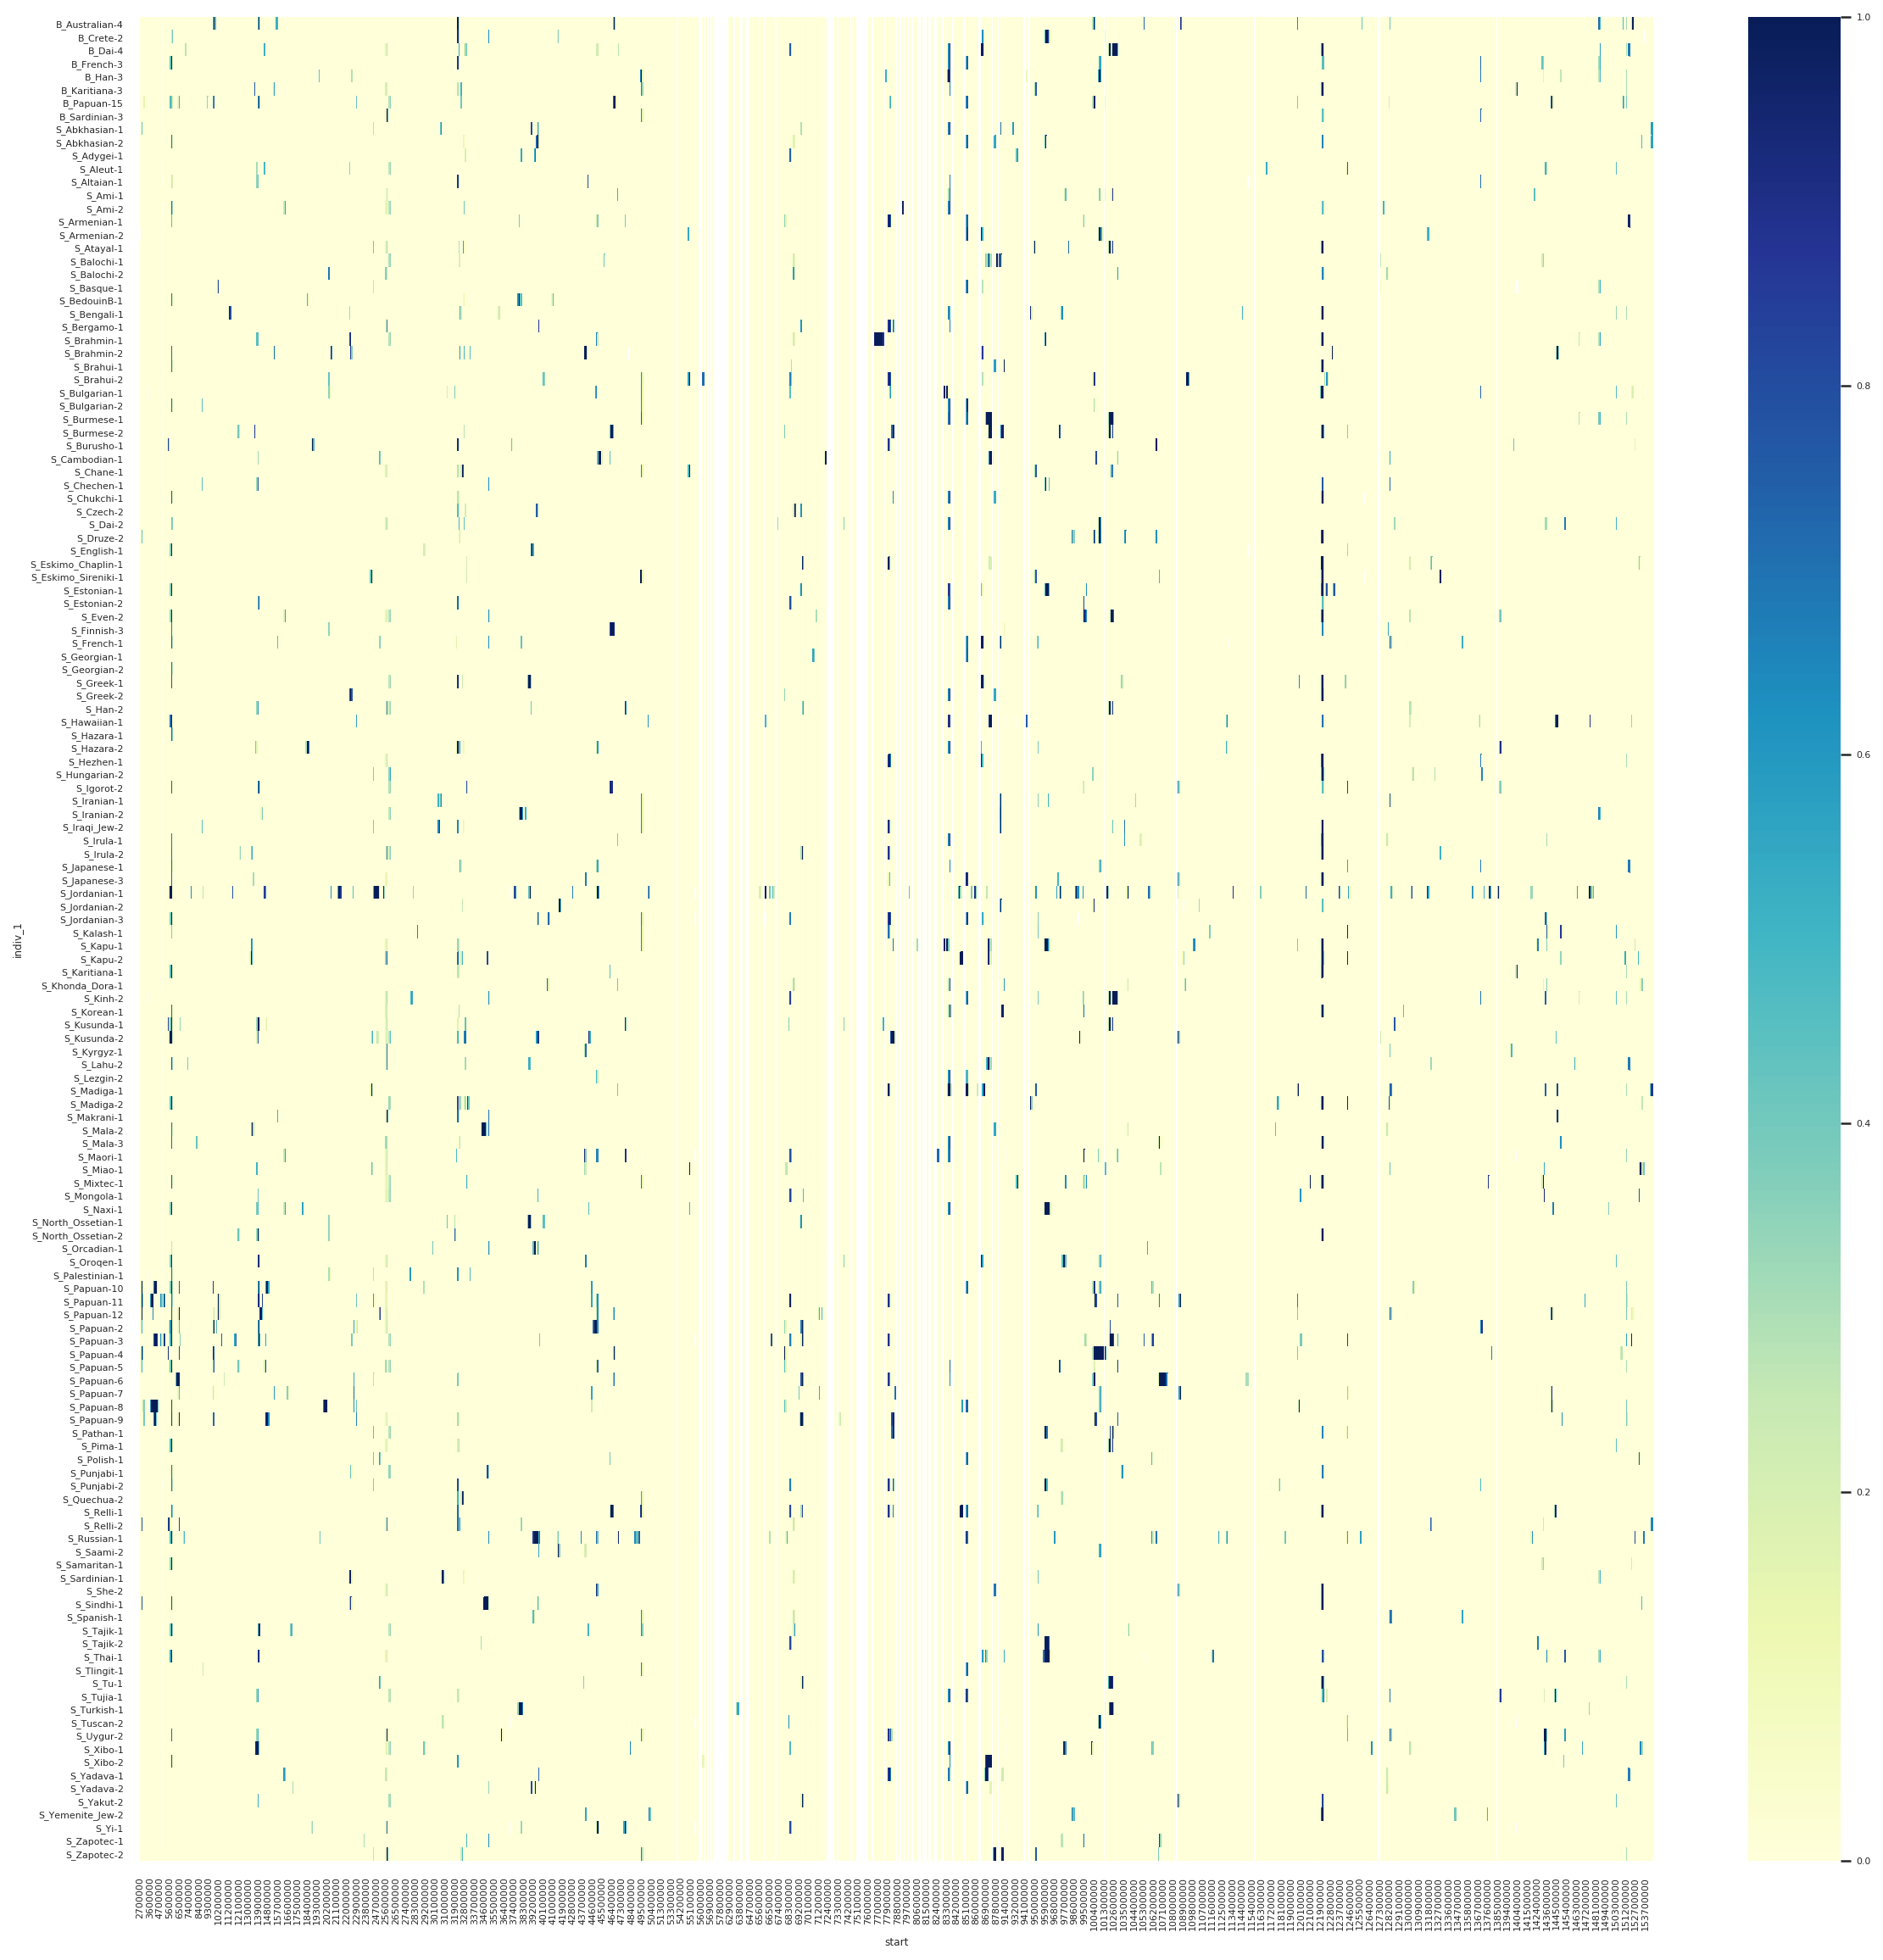

In [17]:
with sns.plotting_context('notebook', font_scale=0.5):
    plt.figure(figsize=(20, 20))
    sns.heatmap(merged_data.loc[merged_data.region_1 != 'Africa'].pivot('indiv_1', 'start', 'admix_prop'), cmap="YlGnBu")

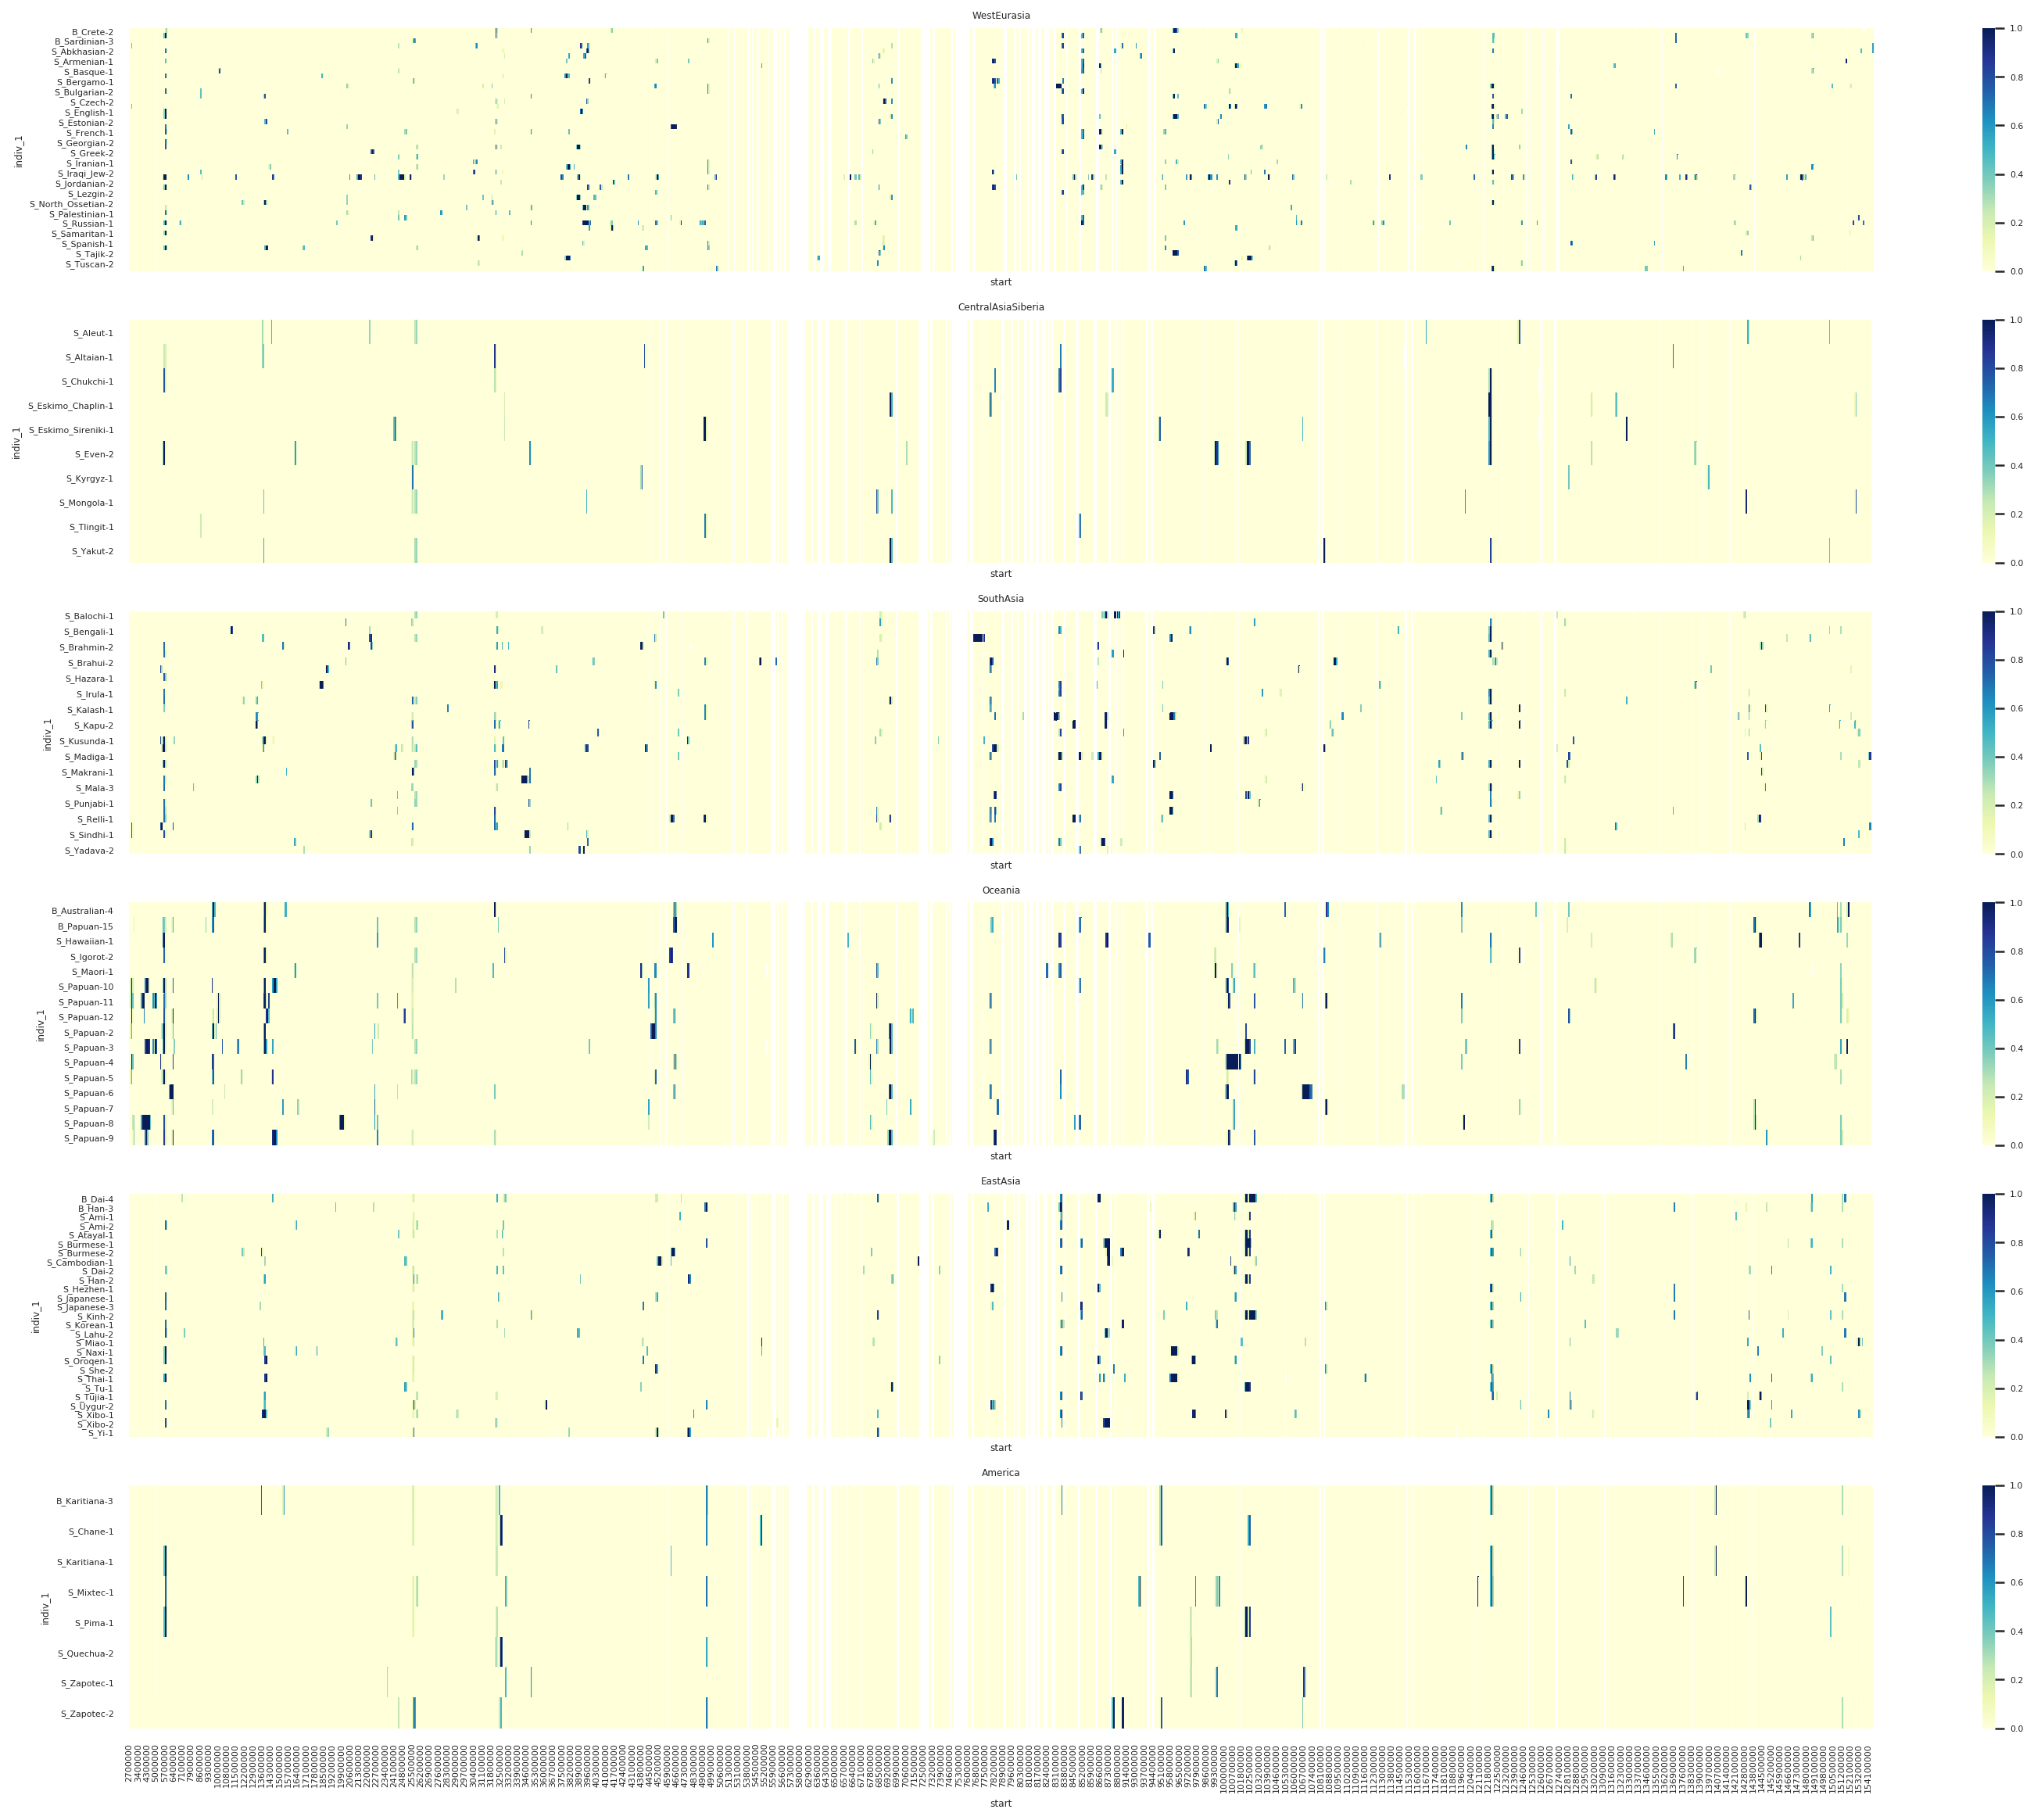

In [18]:
with sns.plotting_context('notebook', font_scale=0.5):
    fig, axes = plt.subplots(6, 1, figsize=(25,20), sharex=True)
    for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
        df = merged_data.loc[merged_data.region_label_1 == region]
        table = df.pivot('indiv_1', 'start', 'admix_prop')
        ax = sns.heatmap(table, ax=axes[i], cmap="YlGnBu")
        axes[i].set_title(region)

## Admixture proportions in stratified by `never_swept`

In [19]:
merged_data.groupby('never_swept')['admix_prop'].agg(['mean', 'count'])

mean   count
never_swept                  
False        0.003702   51496
True         0.009950  117881

In [20]:
merged_data.groupby('never_swept_af')['admix_prop'].agg(['mean', 'count'])

mean   count
never_swept_af                  
False           0.004471   54155
True            0.009733  115222

In [21]:
merged_data.groupby(['never_swept', 'never_swept_af'])['admix_prop'].agg(['mean', 'count'])

mean   count
never_swept never_swept_af                  
False       False           0.003702   51496
True        False           0.019357    2659
            True            0.009733  115222

Test difference between `never_swept` `True` and `False`:

In [22]:
scipy.stats.ttest_ind(merged_data.loc[merged_data.never_swept == True, 'admix_prop'],
                      merged_data.loc[merged_data.never_swept == False, 'admix_prop'],
                      nan_policy='omit'
                     )

Ttest_indResult(statistic=15.826293449184677, pvalue=2.2497320167297734e-56)

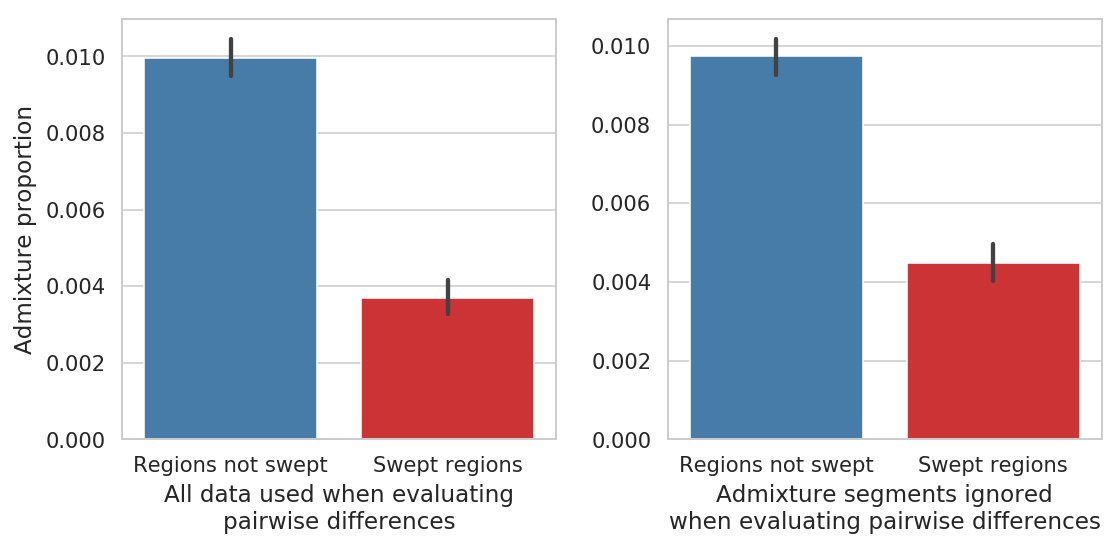

In [23]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.2):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
            g1 = sns.barplot(x="not_never_swept", y="admix_prop", 
                             data=merged_data.assign(not_never_swept=~merged_data.never_swept), 
                             ax=ax1, n_boot=1000)
            g2 = sns.barplot(x="not_never_swept_af", y="admix_prop", 
                                data=merged_data.assign(not_never_swept_af=~merged_data.never_swept_af), 
                             ax=ax2)
            
            g1.set_ylabel("Admixture proportion")
            g2.set_ylabel("")
            g1.set_xlabel("All data used when evaluating\npairwise differences")
            g2.set_xlabel("Admixture segments ignored\nwhen evaluating pairwise differences")
            
            g1.set_xticklabels(['Regions not swept', 'Swept regions'])
            g2.set_xticklabels(['Regions not swept', 'Swept regions'])

            
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'admix_in_swept_regions.pdf'))
            plt.savefig(str(figures_dir / 'admix_in_swept_regions.png'))



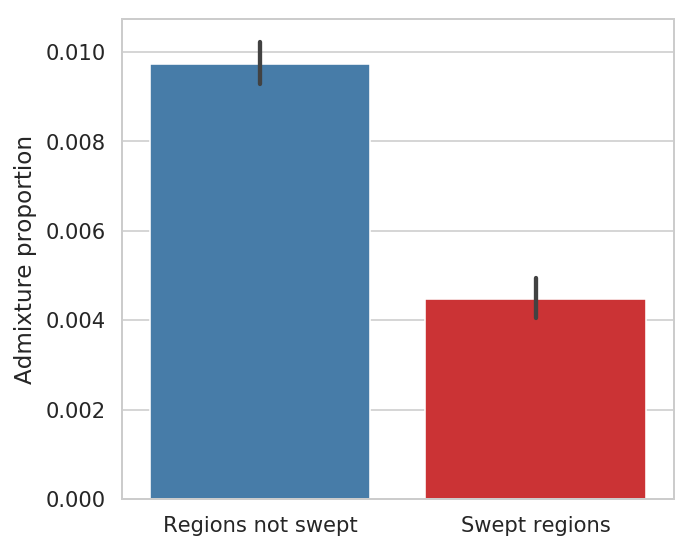

In [24]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.2):
        with sns.axes_style('whitegrid'):
            fig, ax2 = plt.subplots(1, figsize=(5,4))
            g = sns.barplot(x="not_never_swept_af", y="admix_prop", 
                                data=merged_data.assign(not_never_swept_af=~merged_data.never_swept_af), 
                             ax=ax2)
            
            g.set_ylabel("Admixture proportion")
            g.set_xlabel('')
            g.set_xticklabels(['Regions not swept', 'Swept regions'])
                        
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'admix_in_swept_regions_af.pdf'))


## Admixture proportions only in windows that are `swept` in some males and not in others

In [25]:
df = (merged_data.loc[lambda df: (df.partial_sweep_win == True),# & (df.conserv_swept_group != 'ambig'),
                          ['indiv_1', 'region_1', 'start', 'swept', 'admix_prop']]
      
                  # removing 'ambig' creates windows that does not have both swept and non-swept
                  # so we need to filter to get only windows that include both calls:
                  .groupby(['start']).filter(lambda df: set(df['swept']) == set([False, True]))
      
           .melt(id_vars=['indiv_1', 'region_1', 'start', 'admix_prop'], 
                 value_vars=['swept'], 
                 var_name='call',
                value_name='is_swept')
          )

df_af = (merged_data.loc[lambda df: (df.partial_sweep_win_af == True),# & (df.conserv_swept_group_af != 'ambig'),
                          ['indiv_1', 'region_1', 'start', 'swept_af', 'admix_prop']]
         
         
                  # removing 'ambig' creates windows that does not have both swept and non-swept
                  # so we need to filter to get only windows that include both calls:
                  .groupby(['start']).filter(lambda df: set(df['swept_af']) == set([False, True]))
         
           .melt(id_vars=['indiv_1', 'region_1', 'start', 'admix_prop'], 
                 value_vars=['swept_af'], 
                 var_name='call',
                value_name='is_swept')
          )

plot_df = pandas.concat([df, df_af])
plot_df['region_1'] = plot_df.region_1.astype('category').cat.set_categories(
    ['Africa', 'WestEurasia', 'SouthAsia', 'CentralAsiaSiberia', 'Oceania', 'EastAsia', 'America'])

plot_df = plot_df.loc[lambda df: df.region_1 != 'Africa']


# plot_df['region_1'] 
plot_df['region_1'] = plot_df.region_1.cat.remove_unused_categories()

plot_df.head()

indiv_1 region_1     start  admix_prop   call  is_swept
0  B_Australian-4  Oceania  10200000         0.0  swept     False
1  B_Australian-4  Oceania  10300000         0.0  swept     False
2  B_Australian-4  Oceania  10400000         0.0  swept     False
3  B_Australian-4  Oceania  10500000         0.0  swept     False
4  B_Australian-4  Oceania  10600000         0.0  swept     False

In [26]:
df = plot_df.groupby(['call', 'is_swept'])['admix_prop'].agg(['mean', 'sem'])
df

mean       sem
call     is_swept                    
swept    False     0.005676  0.000352
         True      0.000103  0.000041
swept_af False     0.005791  0.000350
         True      0.000606  0.000139

Reduction in admixture proportion in ECHs compared to ECHs in the same windows

In [27]:
(df.loc[('swept', False), 'mean'] - df.loc[('swept', True), 'mean']) / df.loc[('swept', False), 'mean']

0.98189987131767809

Plots are based on this many 100kb windows along the chromosome:

In [28]:
plot_df.start.drop_duplicates().size

455

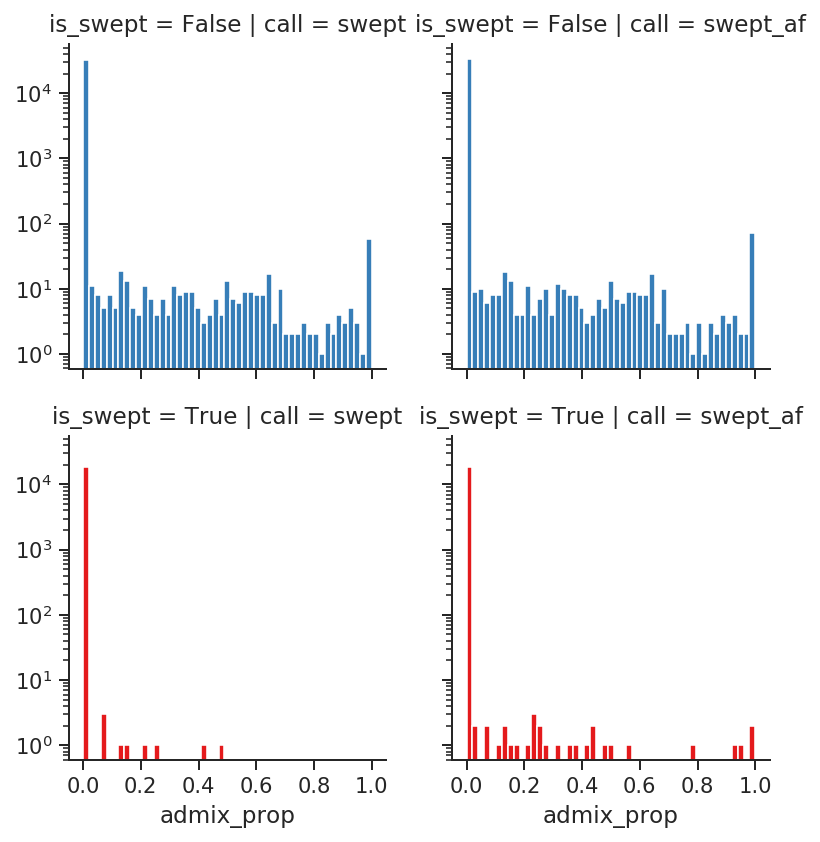

In [29]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.FacetGrid(row='is_swept', col='call', hue='is_swept', data=plot_df, sharex=True, sharey=True)
            g.map(plt.hist, 'admix_prop', bins=numpy.linspace(0, 1, 50))
            
#             g = sns.stripplot(x='call', y='admix_prop', hue='is_swept', jitter=True, dodge=True, data=plot_df)
#             g.set_ylabel('Mean admixture proportion')
#             g.set_xlabel('')
#             g.set_xticklabels(['All data used when evaluating\npairwise differences', 
#                                'Admixture segments ignored\nwhen evaluating pairwise distances'])
            
            [ax.set_yscale('log') for ax in g.axes.flat]

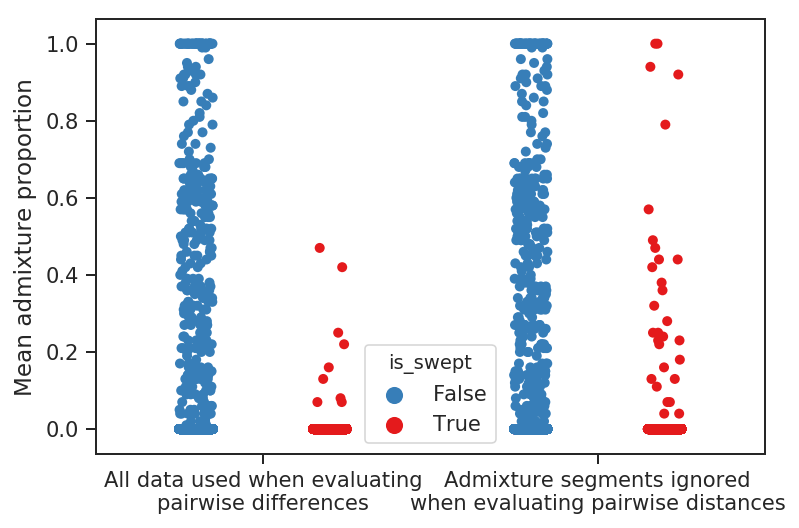

In [30]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.stripplot(x='call', y='admix_prop', hue='is_swept', jitter=True, dodge=True, data=plot_df)
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['All data used when evaluating\npairwise differences', 
                               'Admixture segments ignored\nwhen evaluating pairwise distances'])
#            g.set_yscale('log')

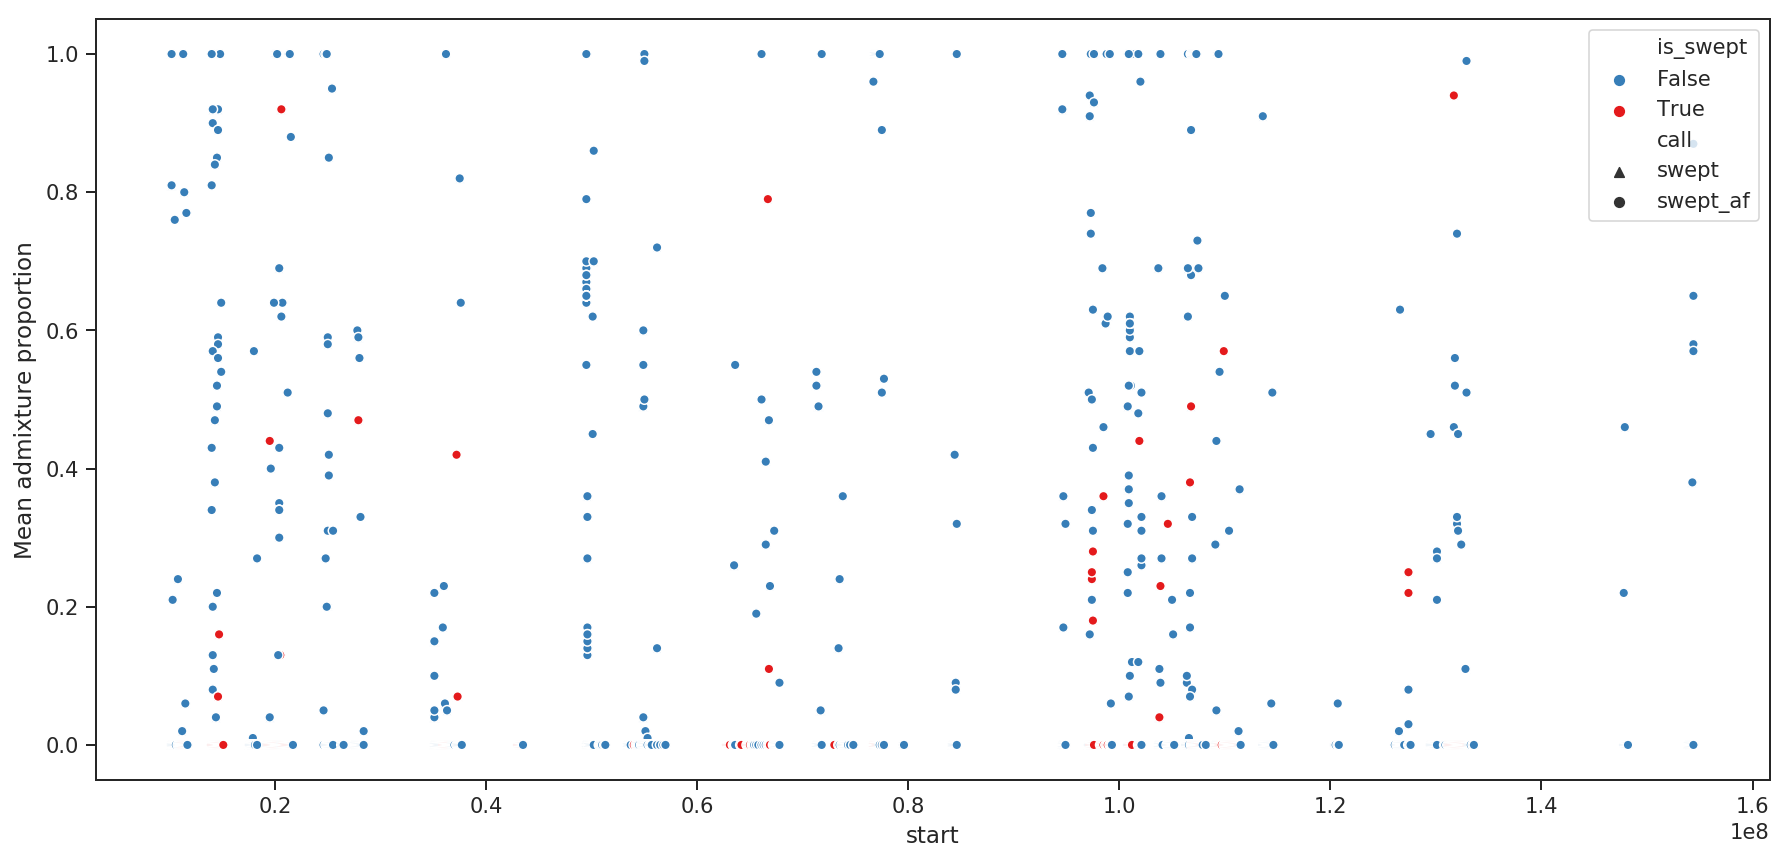

In [31]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            plt.figure(figsize=(15,7))
            g = sns.scatterplot(x='start', y='admix_prop', style='call', hue='is_swept', markers=['^', 'o'], data=plot_df)
            g.set_ylabel('Mean admixture proportion')

In [32]:
#pandas.pivot_table(plot_df, index=['start', 'admix_prop'], columns='is_swept')

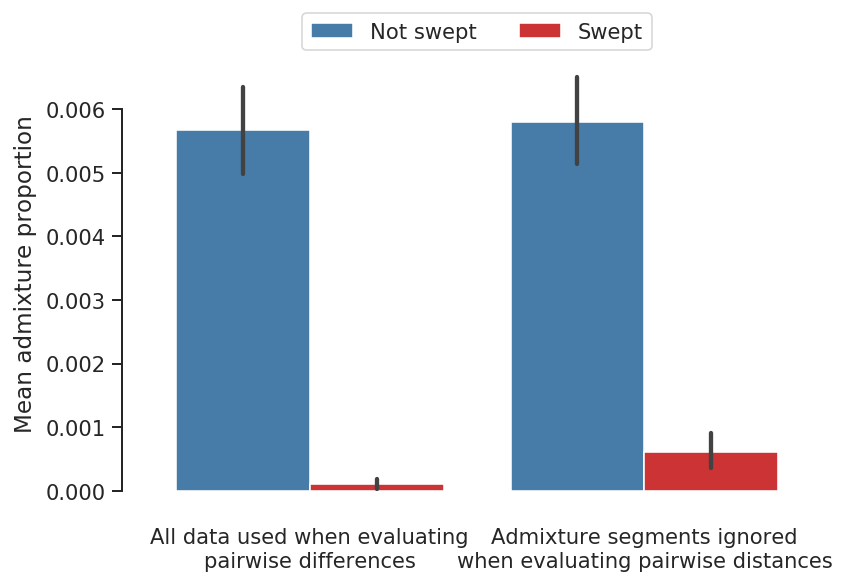

In [33]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.barplot(x='call', y='admix_prop', hue='is_swept', data=plot_df)
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['All data used when evaluating\npairwise differences', 
                               'Admixture segments ignored\nwhen evaluating pairwise distances'])
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()

            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',
                     ncol=2
                    )
            
            sns.despine(trim=True, offset=10)

            plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            ) # labels along the bottom edge are off
            plt.gca().axes.spines['bottom'].set_visible(False)
                
            plt.savefig(str(figures_dir / 'admix_prop_by_call.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_by_call.png'))

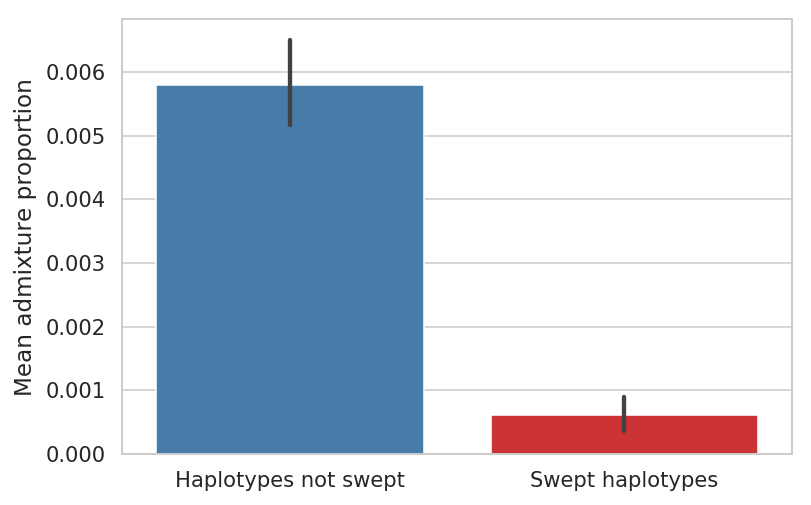

In [34]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.barplot(x='is_swept', y='admix_prop', 
                            data=plot_df.loc[lambda df: df.call == 'swept_af']
                           )
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['Haplotypes not swept', 'Swept haplotypes'])

            plt.savefig(str(figures_dir / 'admix_prop_af.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_af.png'))

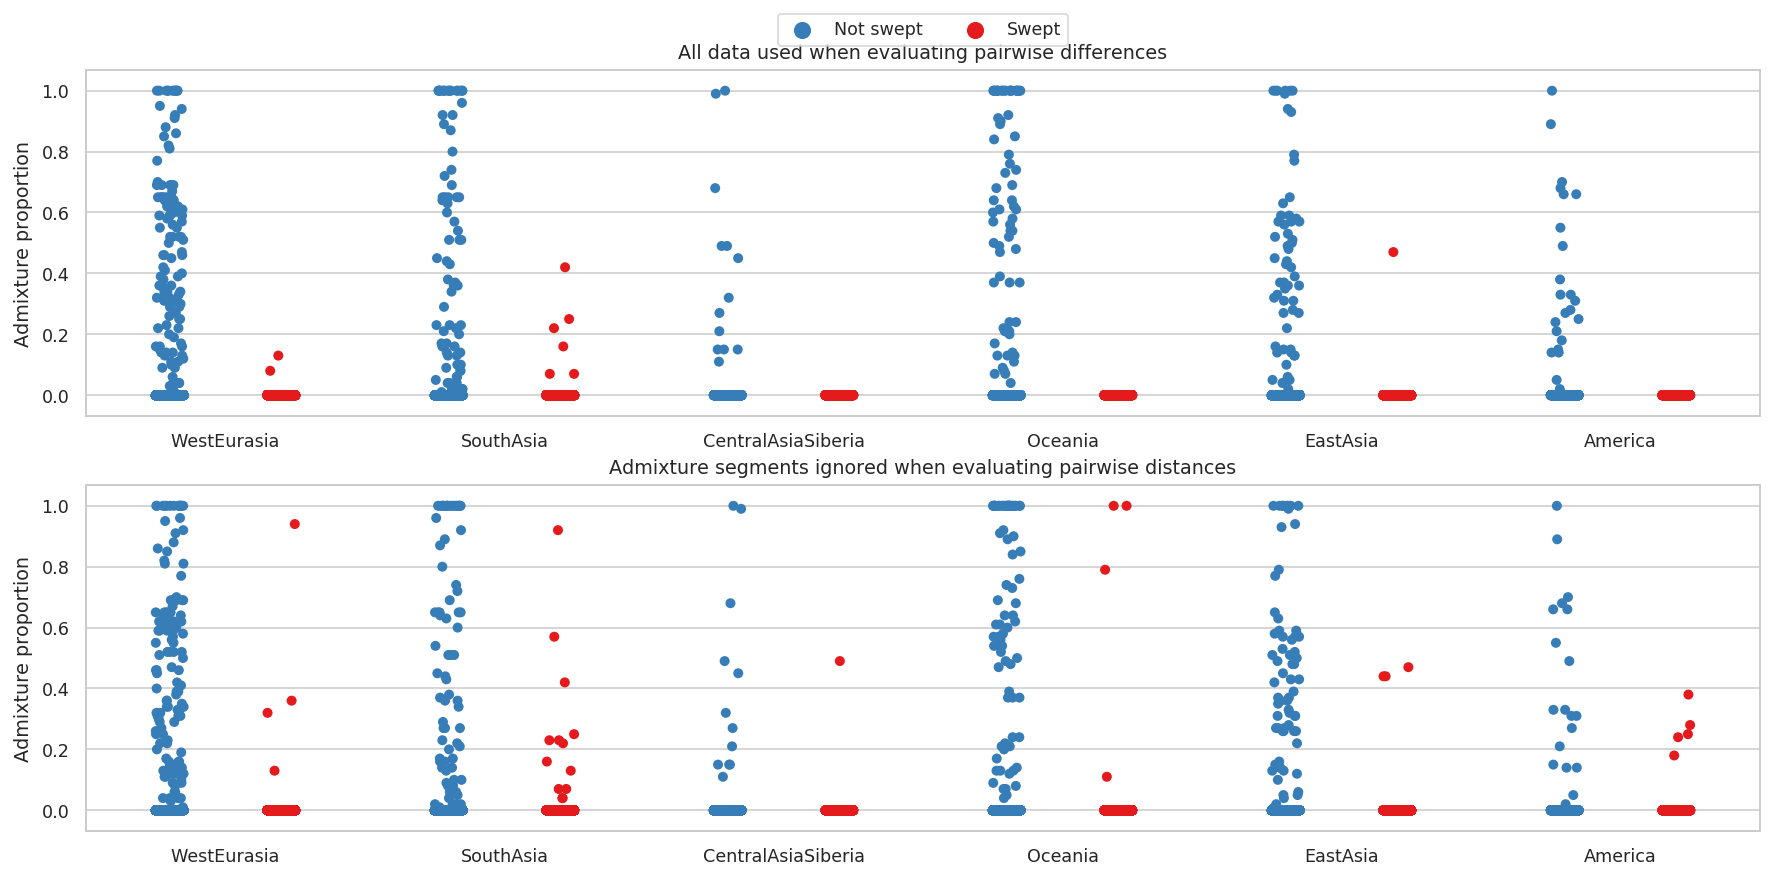

In [35]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharey=True)

            g = sns.stripplot(x='region_1', y='admix_prop', hue='is_swept', jitter=True, dodge=True,
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax1)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )
            ax1.set_title('All data used when evaluating pairwise differences')
            
            g = sns.stripplot(x='region_1', y='admix_prop', hue='is_swept', jitter=True, dodge=True,
                            data=plot_df.loc[lambda df: df.call == 'swept_af'], ax=ax2)
            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')

            ax2.legend().set_visible(False)
            ax2.set_title('Admixture segments ignored when evaluating pairwise distances')

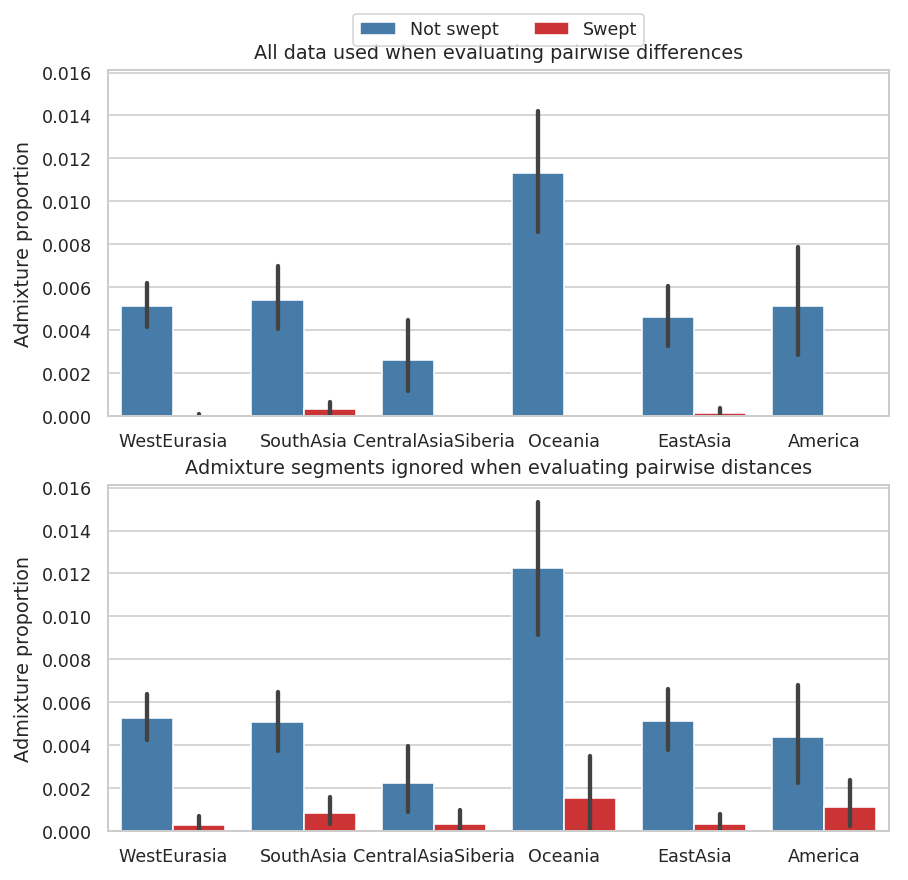

In [36]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharey=True)

            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax1)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )
            ax1.set_title('All data used when evaluating pairwise differences')
            
            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept_af'], ax=ax2)
            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')

            ax2.legend().set_visible(False)
            ax2.set_title('Admixture segments ignored when evaluating pairwise distances')

            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region.png'))

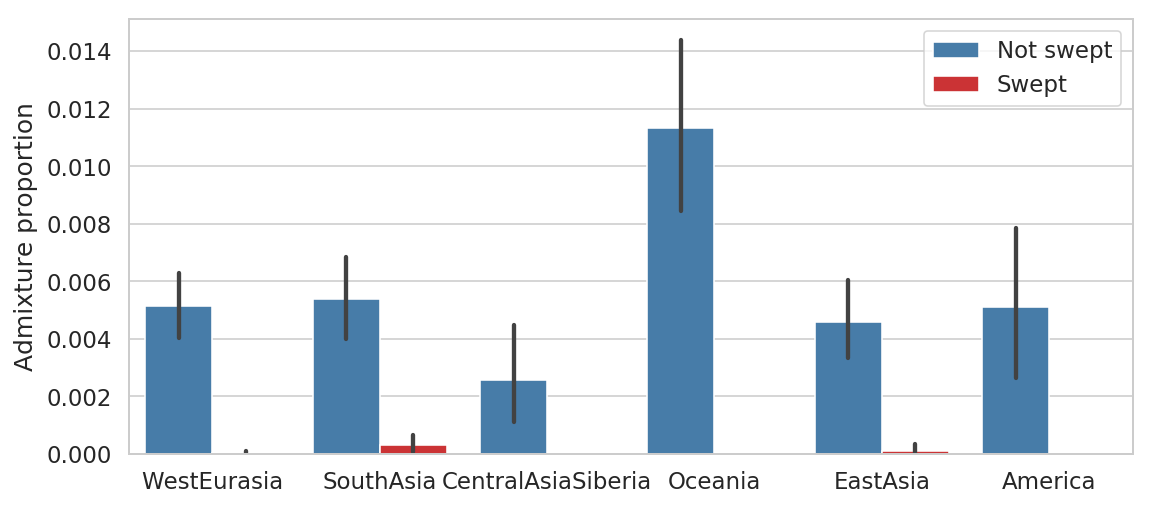

In [37]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.3):
            
            fig, ax = plt.subplots(1, 1, figsize=(9, 4))
                
            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )

            g.legend(handles, ['Not swept', 
                               'Swept',
                              ],
                     loc='upper right',
                     ncol=1
                    )
            plt.savefig(str(figures_dir / 'admix_prop_by_region.pdf'))


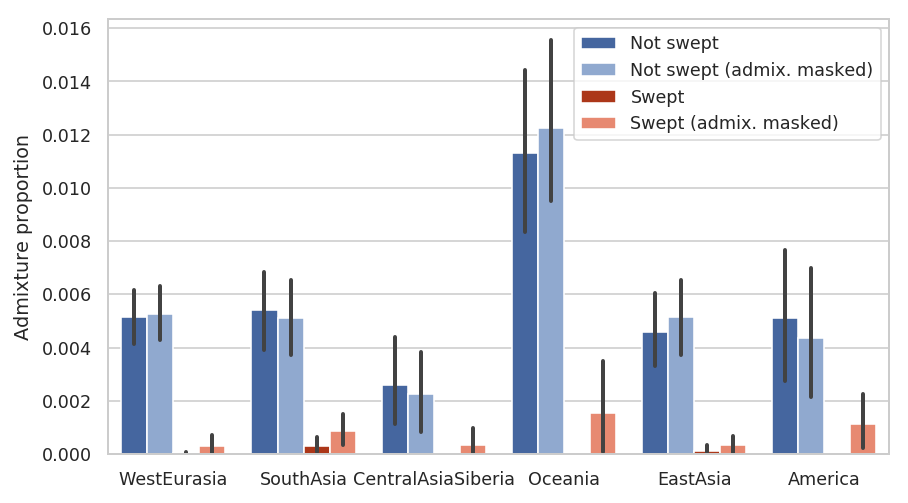

In [38]:
with sns.color_palette(["#3662AE", "#86A7D9", "#C52900", "#FB7D5D"]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, ax1 = plt.subplots(1, 1, figsize=(7, 4))

            g = sns.barplot(x='region_1', y='admix_prop', hue='label', 
                            data=plot_df.assign(label=plot_df.call.astype(str) + "_" + plot_df.is_swept.astype(str)), 
                            hue_order=['swept_False', 'swept_af_False', 'swept_True', 'swept_af_True'],
                            ax=ax1,
                            errwidth=2,
                            #width = .8
                           )

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 
                               'Not swept (admix. masked)',
                               'Swept',
                               'Swept (admix. masked)',
                              ],
                     #bbox_to_anchor=(1., 1.0),  loc='upper left',
                     loc='upper right',
#                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=1
                    )

            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region_version2.pdf'))

Admixture proportions:

In [39]:
(plot_df
 .groupby(['call', 'region_1', 'is_swept'])['admix_prop']
 .agg(['mean', 'sem'])
)

mean       sem
call     region_1           is_swept                    
swept    WestEurasia        False     0.005134  0.000540
                            True      0.000036  0.000026
         SouthAsia          False     0.005397  0.000753
                            True      0.000306  0.000146
         CentralAsiaSiberia False     0.002584  0.000874
                            True      0.000000  0.000000
         Oceania            False     0.011325  0.001518
                            True      0.000000  0.000000
         EastAsia           False     0.004593  0.000717
                            True      0.000119  0.000119
         America            False     0.005127  0.001285
                            True      0.000000  0.000000
swept_af WestEurasia        False     0.005244  0.000540
                            True      0.000295  0.000179
         SouthAsia          False     0.005096  0.000717
                            True      0.000850  0.000323
         CentralAsiaSiberia False     0.002237  0.000802
                            True      0.000327  0.000327
         Oceania            False     0.012244  0.001561
                            True      0.001536  0.000859
         EastAsia           False     0.005140  0.000736
                            True      0.000338  0.000195
         America            False     0.004362  0.001201
                            True      0.001141  0.000525

In the admixture filtered analysis, confidence intervals for mean admixture proportions overlap, or nearly overlap zero. Add to that that Laurit's method has a false positive rate of 5-10%.

In [40]:
(plot_df.loc[lambda df: (df.call=='swept_af') & (df.is_swept==True)]
 .groupby(['call', 'region_1', 'is_swept'])['admix_prop']
 .agg(['mean', 'sem'])
 .reset_index()
 .assign(non_zero=lambda df: df['mean']-1.96*df['sem'])
)

call            region_1  is_swept      mean       sem  non_zero
0  swept_af         WestEurasia      True  0.000295  0.000179 -0.000056
1  swept_af           SouthAsia      True  0.000850  0.000323  0.000218
2  swept_af  CentralAsiaSiberia      True  0.000327  0.000327 -0.000314
3  swept_af             Oceania      True  0.001536  0.000859 -0.000149
4  swept_af            EastAsia      True  0.000338  0.000195 -0.000045
5  swept_af             America      True  0.001141  0.000525  0.000113

### Chromosome wide admixture proportion excluding the swept haplotypes we call:

Compute mean admixture of each 100kb window when sweept windows are excluded and then compute chromosome mean:

In [41]:
chrom_admix_without_sweeps = (plot_df
 .loc[lambda df: (df.call=='swept_af') & (df.is_swept==False)]
 .groupby(['start'])
 .agg('mean')
 .reset_index()
 .agg(['mean', 'sem'])
 .transpose()
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
 .loc[['admix_prop']]                              
)
chrom_admix_without_sweeps

mean       sem     lower     upper
admix_prop  0.00642  0.000882  0.004692  0.008148

In [42]:
chrom_admix = (plot_df
 .groupby(['start'])
 .agg('mean')
 .reset_index()
 .agg(['mean', 'sem'])
 .transpose()
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
 .loc[['admix_prop']]                              
)
chrom_admix

mean      sem     lower     upper
admix_prop  0.003954  0.00052  0.002936  0.004972

In [43]:
(chrom_admix_without_sweeps['mean'] - chrom_admix['mean']) / chrom_admix_without_sweeps['mean']

admix_prop    0.384096
Name: mean, dtype: float64

Same but by region:

In [44]:
chrom_admix_without_sweeps_by_region = (plot_df
 .loc[lambda df: (df.call=='swept_af') & (df.is_swept==False)]
 .groupby(['region_1', 'start'])
 .agg('mean')
 .reset_index()
 .groupby('region_1')['admix_prop']
 .agg(['mean', 'sem'])
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
)
chrom_admix_without_sweeps_by_region

mean       sem     lower     upper
region_1                                                  
WestEurasia         0.005502  0.000912  0.003715  0.007289
SouthAsia           0.006840  0.001250  0.004391  0.009289
CentralAsiaSiberia  0.003236  0.001436  0.000423  0.006050
Oceania             0.011575  0.002137  0.007387  0.015764
EastAsia            0.005231  0.001242  0.002797  0.007665
America             0.003976  0.001853  0.000345  0.007607

Same computation but inlcuding all windows for al individuals:

In [45]:
chrom_admix_by_region = (plot_df
 .groupby(['region_1', 'start'])
 .agg('mean')
 .reset_index()
 .groupby('region_1')['admix_prop']
 .agg(['mean', 'sem'])
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
)
chrom_admix_by_region

mean       sem     lower     upper
region_1                                                  
WestEurasia         0.003596  0.000554  0.002509  0.004683
SouthAsia           0.003646  0.000551  0.002566  0.004725
CentralAsiaSiberia  0.001468  0.000594  0.000304  0.002631
Oceania             0.008838  0.001740  0.005429  0.012248
EastAsia            0.003227  0.000673  0.001909  0.004545
America             0.003098  0.001297  0.000556  0.005641

How much higher would the chromosome average admixture level be if we take out swept haplotypes:

In [46]:
(chrom_admix_without_sweeps_by_region['mean'] - chrom_admix_by_region['mean']) / chrom_admix_without_sweeps_by_region['mean']

region_1
WestEurasia           0.346371
SouthAsia             0.467020
CentralAsiaSiberia    0.546471
Oceania               0.236456
EastAsia              0.383098
America               0.220769
Name: mean, dtype: float64

### Plot below is not for use but only for keeping as template in case I do a more thorough analysis on Laurits larger Papuan set.

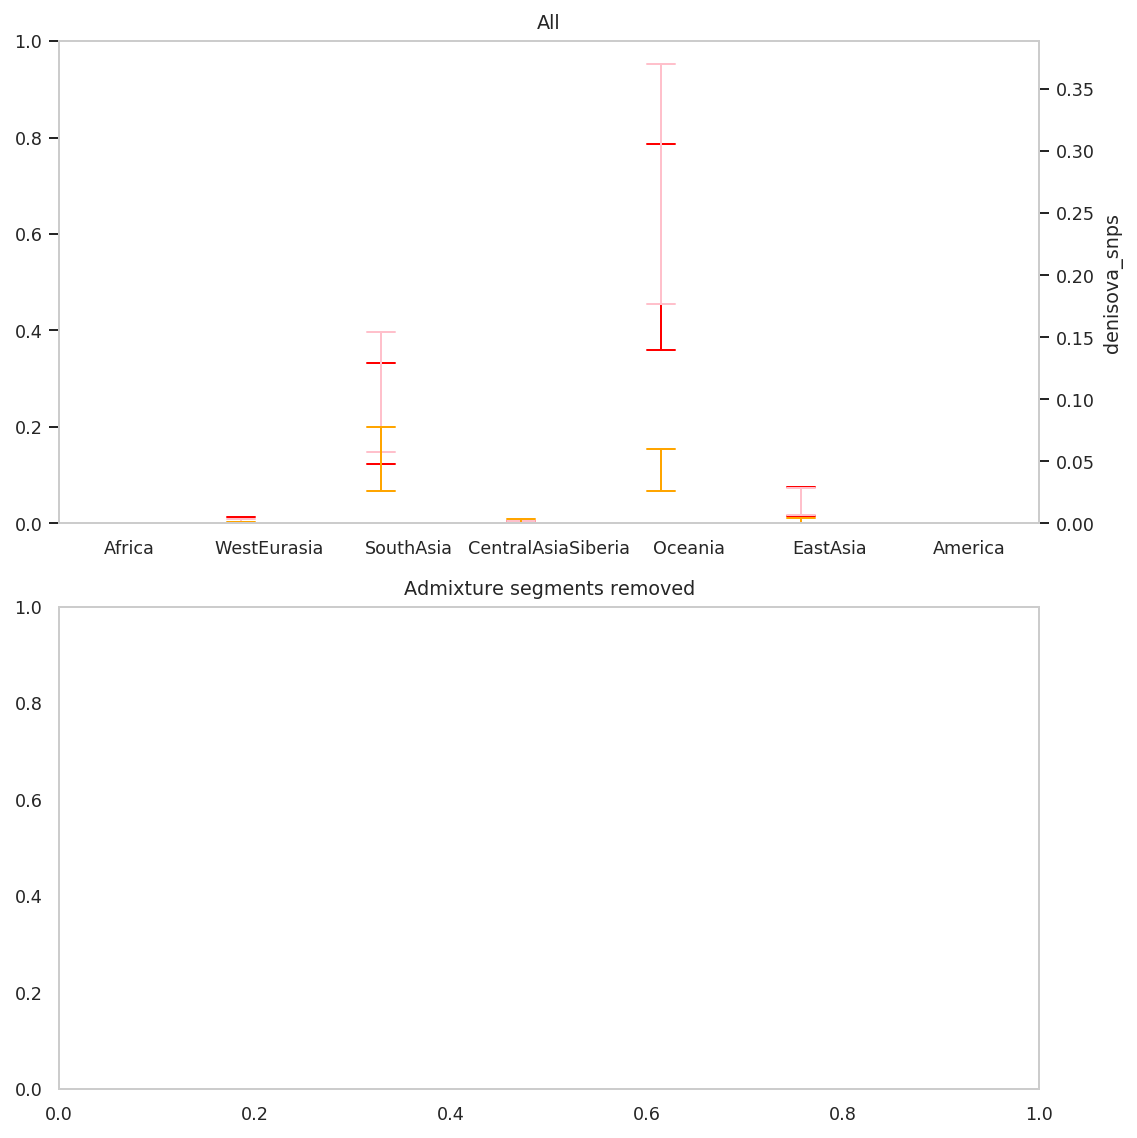

In [47]:
sweep_and_admix_data_subset = (merged_data
                               .groupby(['start'])
                               .filter(lambda df: df.swept.sum() > 0)
                              )

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
#             g = sns.barplot(x="region_1", y="admix_prop", hue='swept', 
#                             data=merged_data.loc[lambda df: (df.never_win_swept == False) & (df.conserv_swept_group != 'ambig')], 
#                             ax=ax1, n_boot=1000)
            ax1.grid(False)
            ax1.set_title("All")

            extra_ax = ax1.twinx()
            sns.barplot(x='region_1', y='altai_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="red")
            sns.barplot(x='region_1', y='vindija_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="pink")
            sns.barplot(x='region_1', y='denisova_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="orange")
            extra_ax.grid(False)
            extra_ax.legend_.remove()

            for item in g.get_xticklabels():
                item.set_rotation(25)

#             g = sns.barplot(x="region_1", y="admix_prop", hue='swept_af', 
#                 data=merged_data.loc[lambda df: (df.never_win_swept_af == False) & (df.conserv_swept_group_af != 'ambig')], 
#                             ax=ax2, n_boot=1000)
            ax2.grid(False)
            ax2.set_title("Admixture segments removed")


            for item in g.get_xticklabels():
                item.set_rotation(25)
                
            plt.tight_layout()
            
#            plt.savefig(str(figures_dir / 'admix_and_sweeps_by_region.png'))

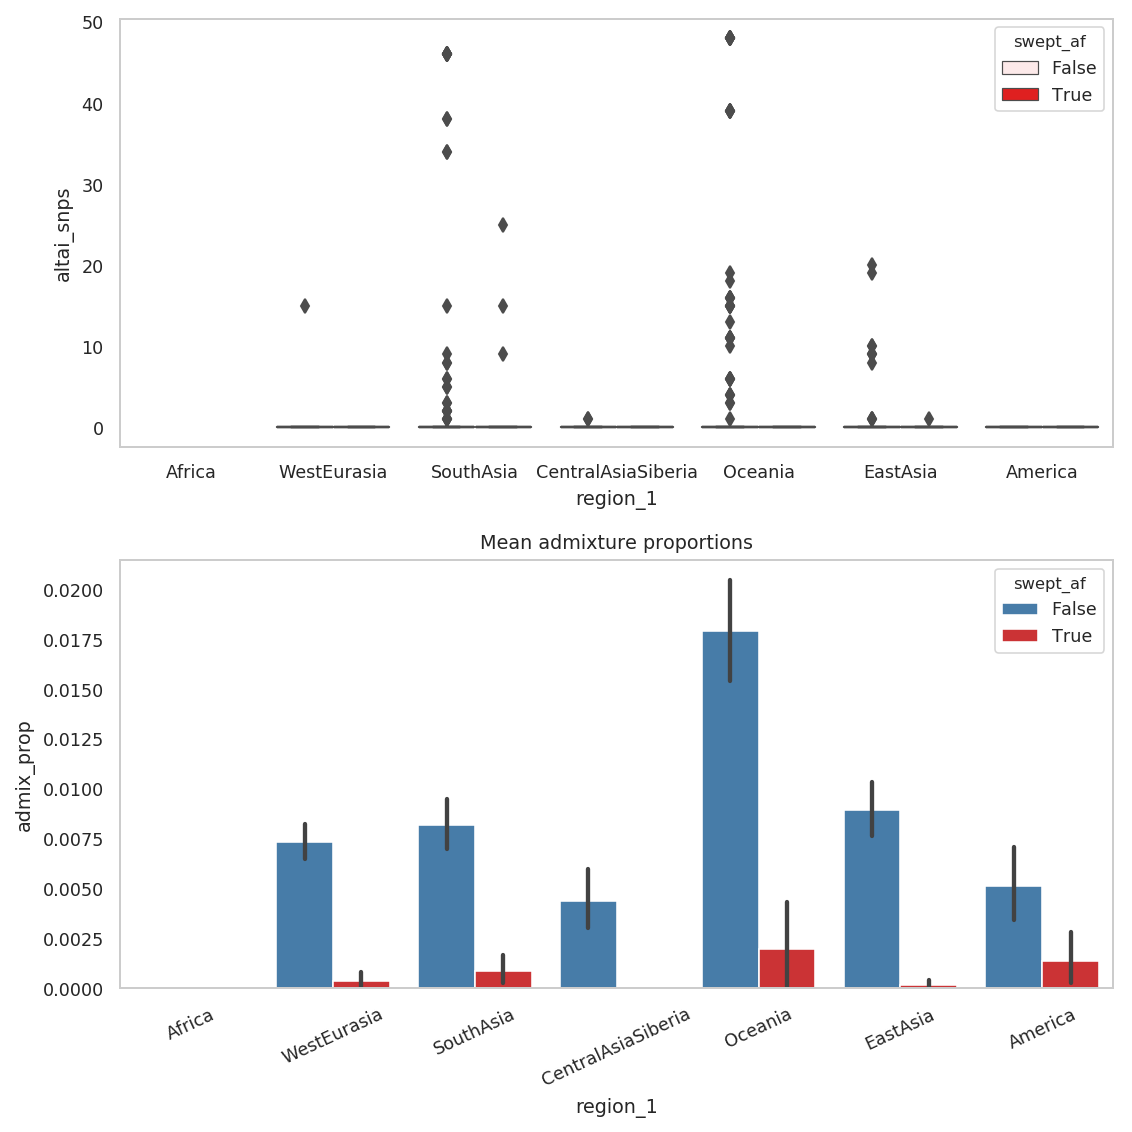

In [48]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

            ax1.grid(False)
            sns.boxplot(x='region_1', y='altai_snps', hue='swept_af', data=sweep_and_admix_data_subset, ax=ax1,
                         color="red")
#             sns.boxplot(x='region_1', y='vindija_snps', hue='swept', data=sweep_and_admix_data_subset, ax=ax1,
#                          color="pink")
#             sns.boxplot(x='region_1', y='denisova_snps', hue='swept', data=sweep_and_admix_data_subset, ax=ax1,
#                          color="orange")

            for item in g.get_xticklabels():
                item.set_rotation(25)

            g = sns.barplot(x="region_1", y="admix_prop", hue='swept_af', 
                data=merged_data.loc[lambda df: (df.never_win_swept_af == False) & (df.conserv_swept_group_af != 'ambig')], 
                            ax=ax2, n_boot=1000)
            ax2.grid(False)
            ax2.set_title("Mean admixture proportions")


            for item in g.get_xticklabels():
                item.set_rotation(25)
                
            plt.tight_layout()
            
#            plt.savefig(str(figures_dir / 'admix_and_sweeps_by_region.png'))

## Which swept windows have admixture when calling with admix filter?

In [49]:
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_data.loc[lambda df: (df.never_win_swept_af == False) & \
#                            (df.conserv_swept_group_af != 'ambig') &  \
                            (df.admix_prop > 0)]
            .sort_values(by=['admix_prop'], ascending=False))

indiv_1      start        end            pop_1  \
142258             S_Kinh-2  102600000  102700000             Kinh   
195087           S_Papuan-7  108700000  108800000           Papuan   
193517           S_Papuan-6  106900000  107000000           Papuan   
193518           S_Papuan-6  107000000  107100000           Papuan   
193519           S_Papuan-6  107100000  107200000           Papuan   
89426          S_Estonian-1   96200000   96300000         Estonian   
89425          S_Estonian-1   96100000   96200000         Estonian   
89424          S_Estonian-1   96000000   96100000         Estonian   
193520           S_Papuan-6  107200000  107300000           Papuan   
88522          S_Estonian-1    5800000    5900000         Estonian   
87407   S_Eskimo_Sireniki-1   49500000   49600000  Eskimo_Sireniki   
87155   S_Eskimo_Sireniki-1   24300000   24400000  Eskimo_Sireniki   
195592           S_Papuan-8    4000000    4100000           Papuan   
193452           S_Papuan-6  100400000  100500000           Papuan   
195593           S_Papuan-8    4100000    4200000           Papuan   
195594           S_Papuan-8    4200000    4300000           Papuan   
82647           S_English-1   39100000   39200000          English   
195595           S_Papuan-8    4300000    4400000           Papuan   
82314           S_English-1    5800000    5900000          English   
195597           S_Papuan-8    4500000    4600000           Papuan   
81713             S_Druze-2  100900000  101000000            Druze   
81708             S_Druze-2  100400000  100500000            Druze   
195752           S_Papuan-8   20000000   20100000           Papuan   
195753           S_Papuan-8   20100000   20200000           Papuan   
193516           S_Papuan-6  106800000  106900000           Papuan   
193143           S_Papuan-6   69500000   69600000           Papuan   
77057               S_Dai-2  100900000  101000000              Dai   
190354           S_Papuan-4  101000000  101100000           Papuan   
104857         S_Hawaiian-1   87300000   87400000         Hawaiian   
188487           S_Papuan-3   69500000   69600000           Papuan   
104042         S_Hawaiian-1    5800000    5900000         Hawaiian   
189373           S_Papuan-4    2900000    3000000           Papuan   
189810           S_Papuan-4   46600000   46700000           Papuan   
190348           S_Papuan-4  100400000  100500000           Papuan   
190351           S_Papuan-4  100700000  100800000           Papuan   
99717             S_Greek-1   38900000   39000000            Greek   
190352           S_Papuan-4  100800000  100900000           Papuan   
190353           S_Papuan-4  100900000  101000000           Papuan   
190355           S_Papuan-4  101100000  101200000           Papuan   
91626              S_Even-2    5800000    5900000             Even   
95555            S_French-1   88300000   88400000           French   
190356           S_Papuan-4  101200000  101300000           Papuan   
190362           S_Papuan-4  101800000  101900000           Papuan   
190954           S_Papuan-5    5800000    5900000           Papuan   
93584           S_Finnish-3   46400000   46500000          Finnish   
93583           S_Finnish-3   46300000   46400000          Finnish   
92563              S_Even-2   99500000   99600000             Even   
192511           S_Papuan-6    6300000    6400000           Papuan   
192512           S_Papuan-6    6400000    6500000           Papuan   
192513           S_Papuan-6    6500000    6600000           Papuan   
195754           S_Papuan-8   20200000   20300000           Papuan   
197147           S_Papuan-9    4300000    4400000           Papuan   
213039            S_Saami-2   41500000   41600000            Saami   
59980            S_Brahui-2  100400000  100500000           Brahui   
208814            S_Relli-1   84600000   84700000            Relli   
208815            S_Relli-1   84700000   84800000            Relli   
64505           S_Burmese-1   

## Correlation between proportion of windows swept and admixture proportion in each individual

There is a relation between amount swept and admixtue, as would be expected if sweeps displace admixture.

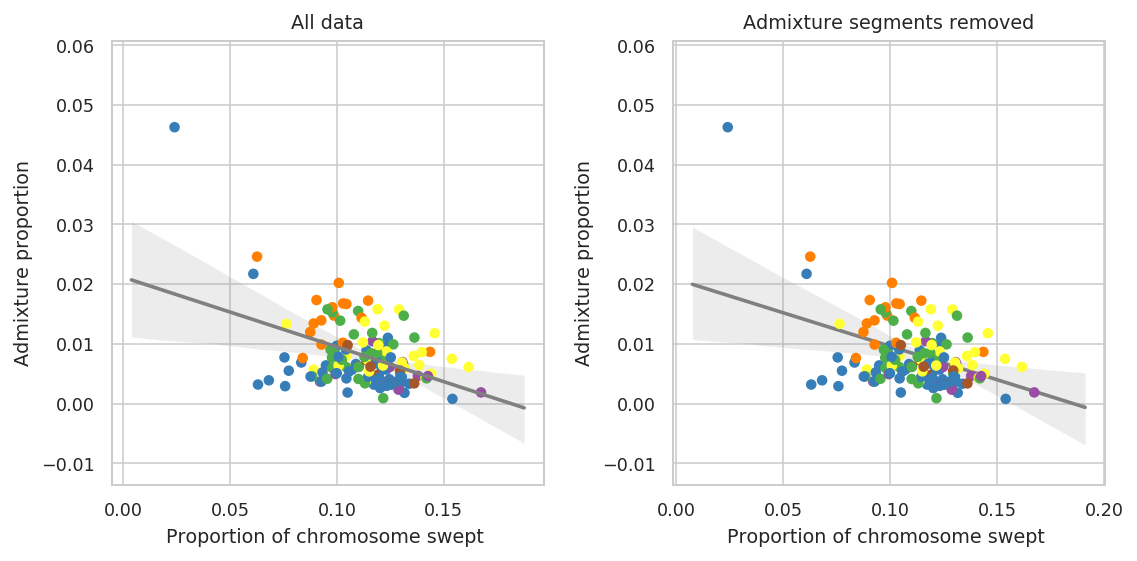

In [50]:
plot_df = (merged_data[['indiv_1', 'region_1', 'swept', 'swept_af', 'admix_prop']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
#           .loc[lambda df: df.admix_prop < 0.03]
           .loc[lambda df: (~numpy.isnan(df.swept)) & (df.region_1 != 'Africa')]
          )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

colors = [region_colors[x] for x in plot_df.region_1]

g = sns.regplot(data=plot_df, x='swept', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax1)
g = ax1.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors,
                     label=colors)
ax1.set_title('All data')
ax1.set_ylabel('Admixture proportion')
ax1.set_xlabel('Proportion of chromosome swept ')


g = sns.regplot(data=plot_df, x='swept_af', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax2)
g = ax2.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors, zorder=3,
                     label=colors)
ax2.set_title('Admixture segments removed')
ax2.set_ylabel('Admixture proportion')
ax2.set_xlabel('Proportion of chromosome swept ')

plt.tight_layout()
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept.png'))
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept.pdf'))


The same but with the following two outliers removed:

In [51]:
print(plot_df.loc[plot_df.admix_prop > 0.03])

           indiv_1     region_1     swept  swept_af  admix_prop
561  S_Jordanian-1  WestEurasia  0.024052  0.027697    0.046272


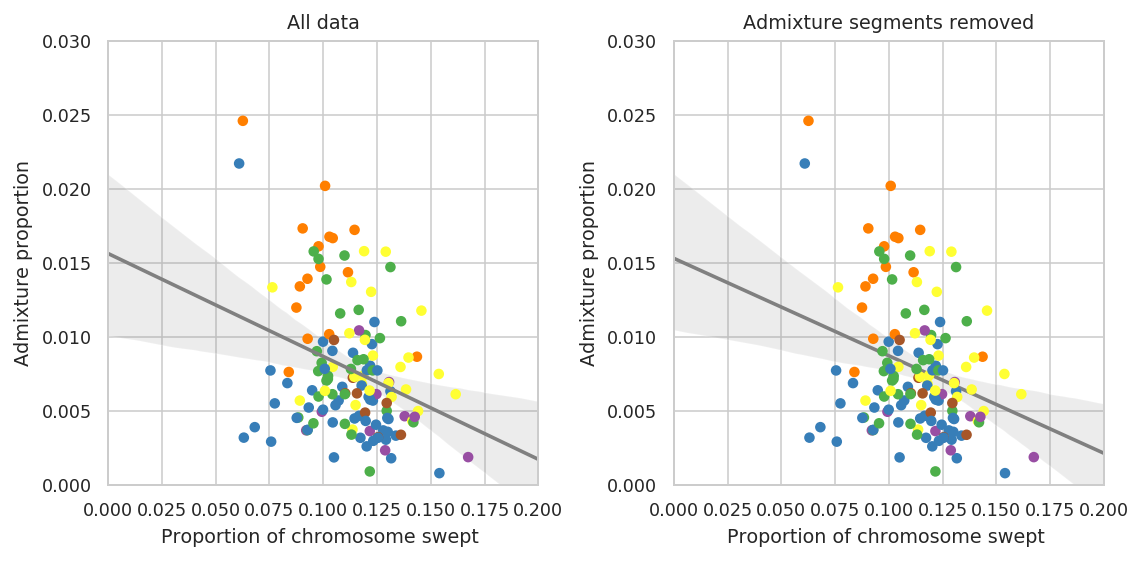

In [52]:
plot_df = (merged_data[['indiv_1', 'region_1', 'swept', 'swept_af', 'admix_prop']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
           .loc[lambda df: df.admix_prop < 0.03]
           .loc[lambda df: (~numpy.isnan(df.swept)) & (df.region_1 != 'Africa')]
          )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

colors = [region_colors[x] for x in plot_df.region_1]

ax1.set_ylim(0, 0.03)
ax1.set_xlim(0, 0.2)
ax2.set_ylim(0, 0.03)
ax2.set_xlim(0, 0.2)

g = sns.regplot(data=plot_df, x='swept', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax1)
g = ax1.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors,
                     label=colors)
ax1.set_title('All data')
ax1.set_ylabel('Admixture proportion')
ax1.set_xlabel('Proportion of chromosome swept ')


g = sns.regplot(data=plot_df, x='swept_af', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax2)
g = ax2.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors, zorder=3,
                     label=colors)
ax2.set_title('Admixture segments removed')
ax2.set_ylabel('Admixture proportion')
ax2.set_xlabel('Proportion of chromosome swept ')

plt.tight_layout()
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept_outliers_rm.png'))
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept_outliers_rm.pdf'))


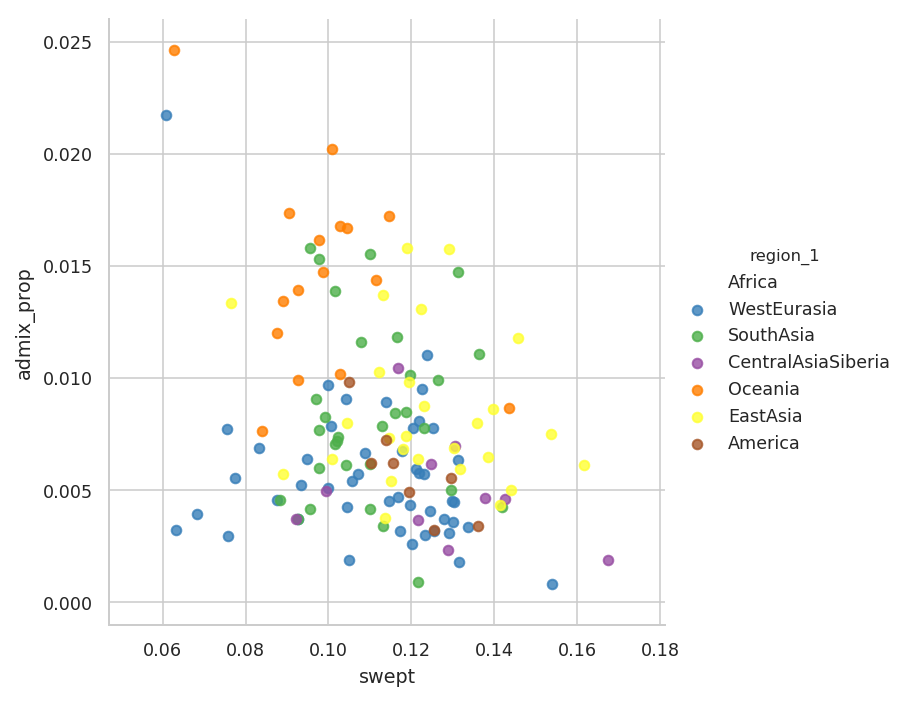

In [53]:
g = sns.lmplot(data=plot_df, 
               x='swept', y='admix_prop', hue='region_1', 
               fit_reg=False, palette='Set1')

## Admixture proportions across the X chromosome

Admixture and 75% regions:

In [81]:
# plot_df = merged_data.loc[~merged_data.region_1.isin(['Africa']),
#                     ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
# plot_df['admix_prop_not_sweept'] = merged_data.loc[(merged_data.swept == False) & ~merged_data.region_1.isin(['Africa']), 
#                       ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
# plot_df.reset_index(inplace=True)
# plot_df = stairs(plot_df)
# plot_df.head()

win_means = merged_data.loc[~merged_data.region_1.isin(['Africa']),
                    ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
win_means['admix_prop_not_sweept'] = merged_data.loc[(merged_data.swept == False) & ~merged_data.region_1.isin(['Africa']), 
                      ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
win_means['nr_swept'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.sum()
win_means['nr_total'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.size()
win_means['prop_swept'] = win_means.nr_swept / win_means.nr_total
win_means.reset_index(inplace=True)

win_means.head()

start      end  admix_prop  admix_prop_not_sweept  nr_swept  nr_total  \
0  2700000  2800000    0.000000               0.000000       0.0       139   
1  2800000  2900000    0.005429               0.005429       0.0       140   
2  2900000  3000000    0.053143               0.053143       0.0       140   
3  3000000  3100000    0.011500               0.011500       0.0       140   
4  3100000  3200000    0.006429               0.006429       0.0       140   

   prop_swept  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

## Proportional reduction in admixture versus proportion swept

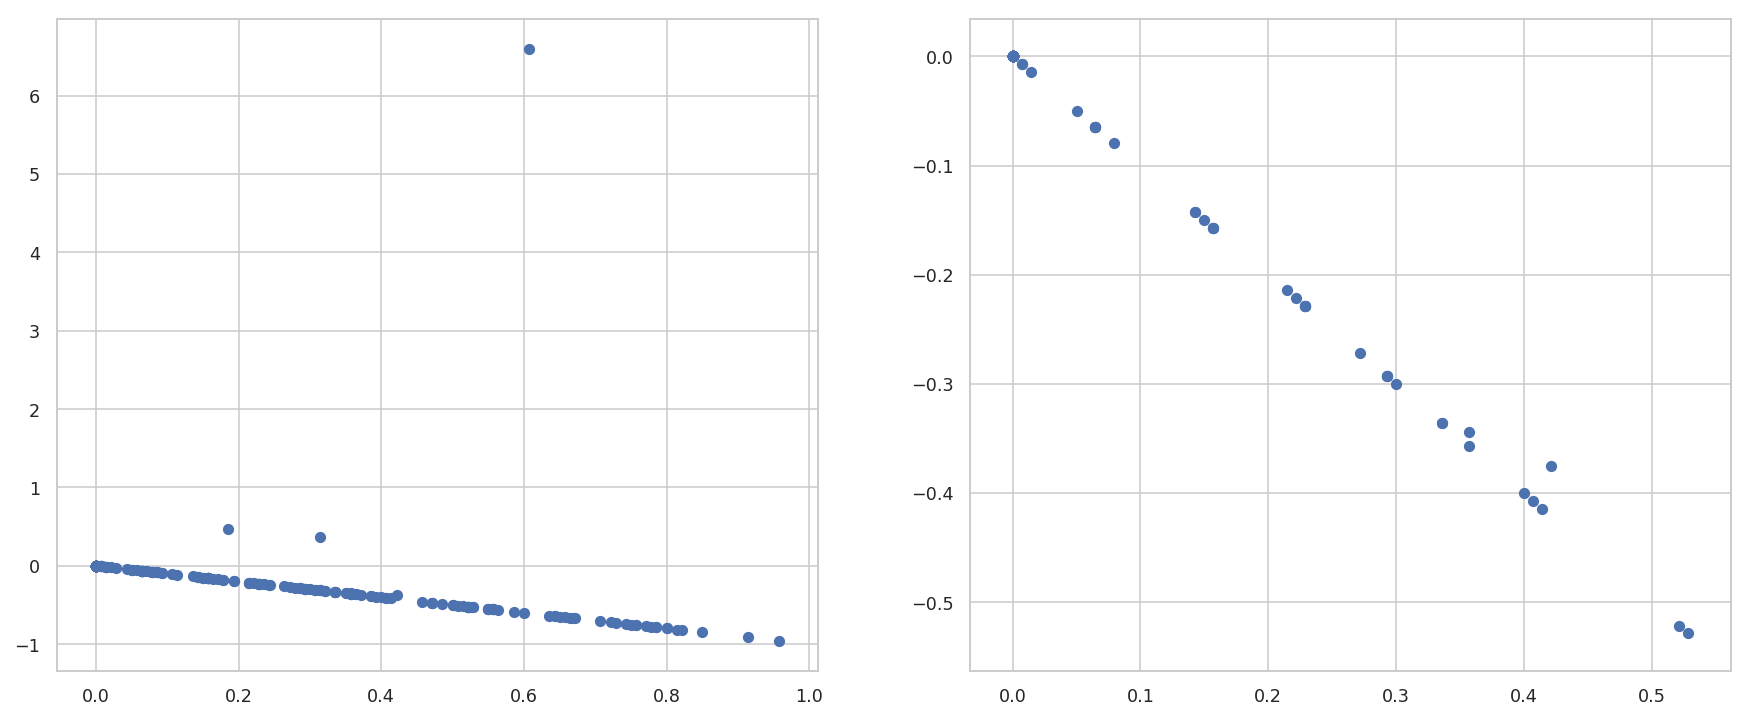

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_df = win_means
ax1.scatter(plot_df.prop_swept, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept) ;
plot_df = win_means.loc[win_means.admix_prop > 0.01]
ax2.scatter(plot_df.prop_swept, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept) ;

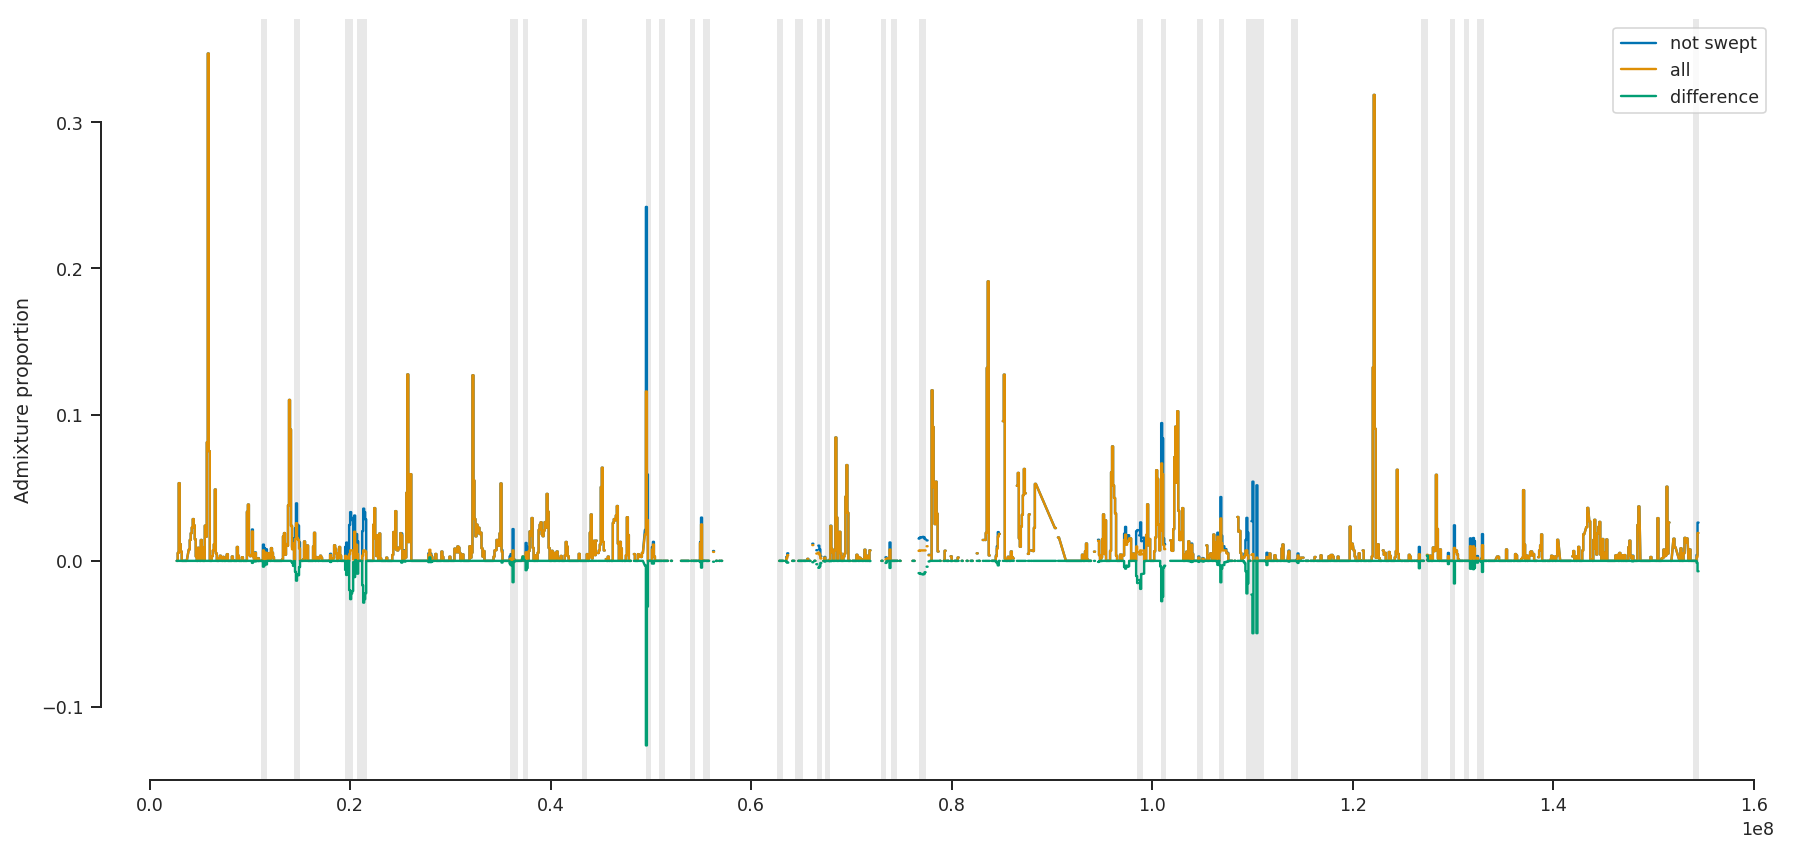

In [82]:
plot_df = stairs(win_means)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, ax1 = plt.subplots(1, 1, figsize=(15,7))
        ax1.plot(plot_df.pos, plot_df.admix_prop_not_sweept, label='not swept')
        ax1.plot(plot_df.pos, plot_df.admix_prop, label='all')
        ax1.plot(plot_df.pos, plot_df.admix_prop - plot_df.admix_prop_not_sweept, label='difference')
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_75.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
            
        sns.despine(trim=True)

## Relative reduction in regions with sweeps 

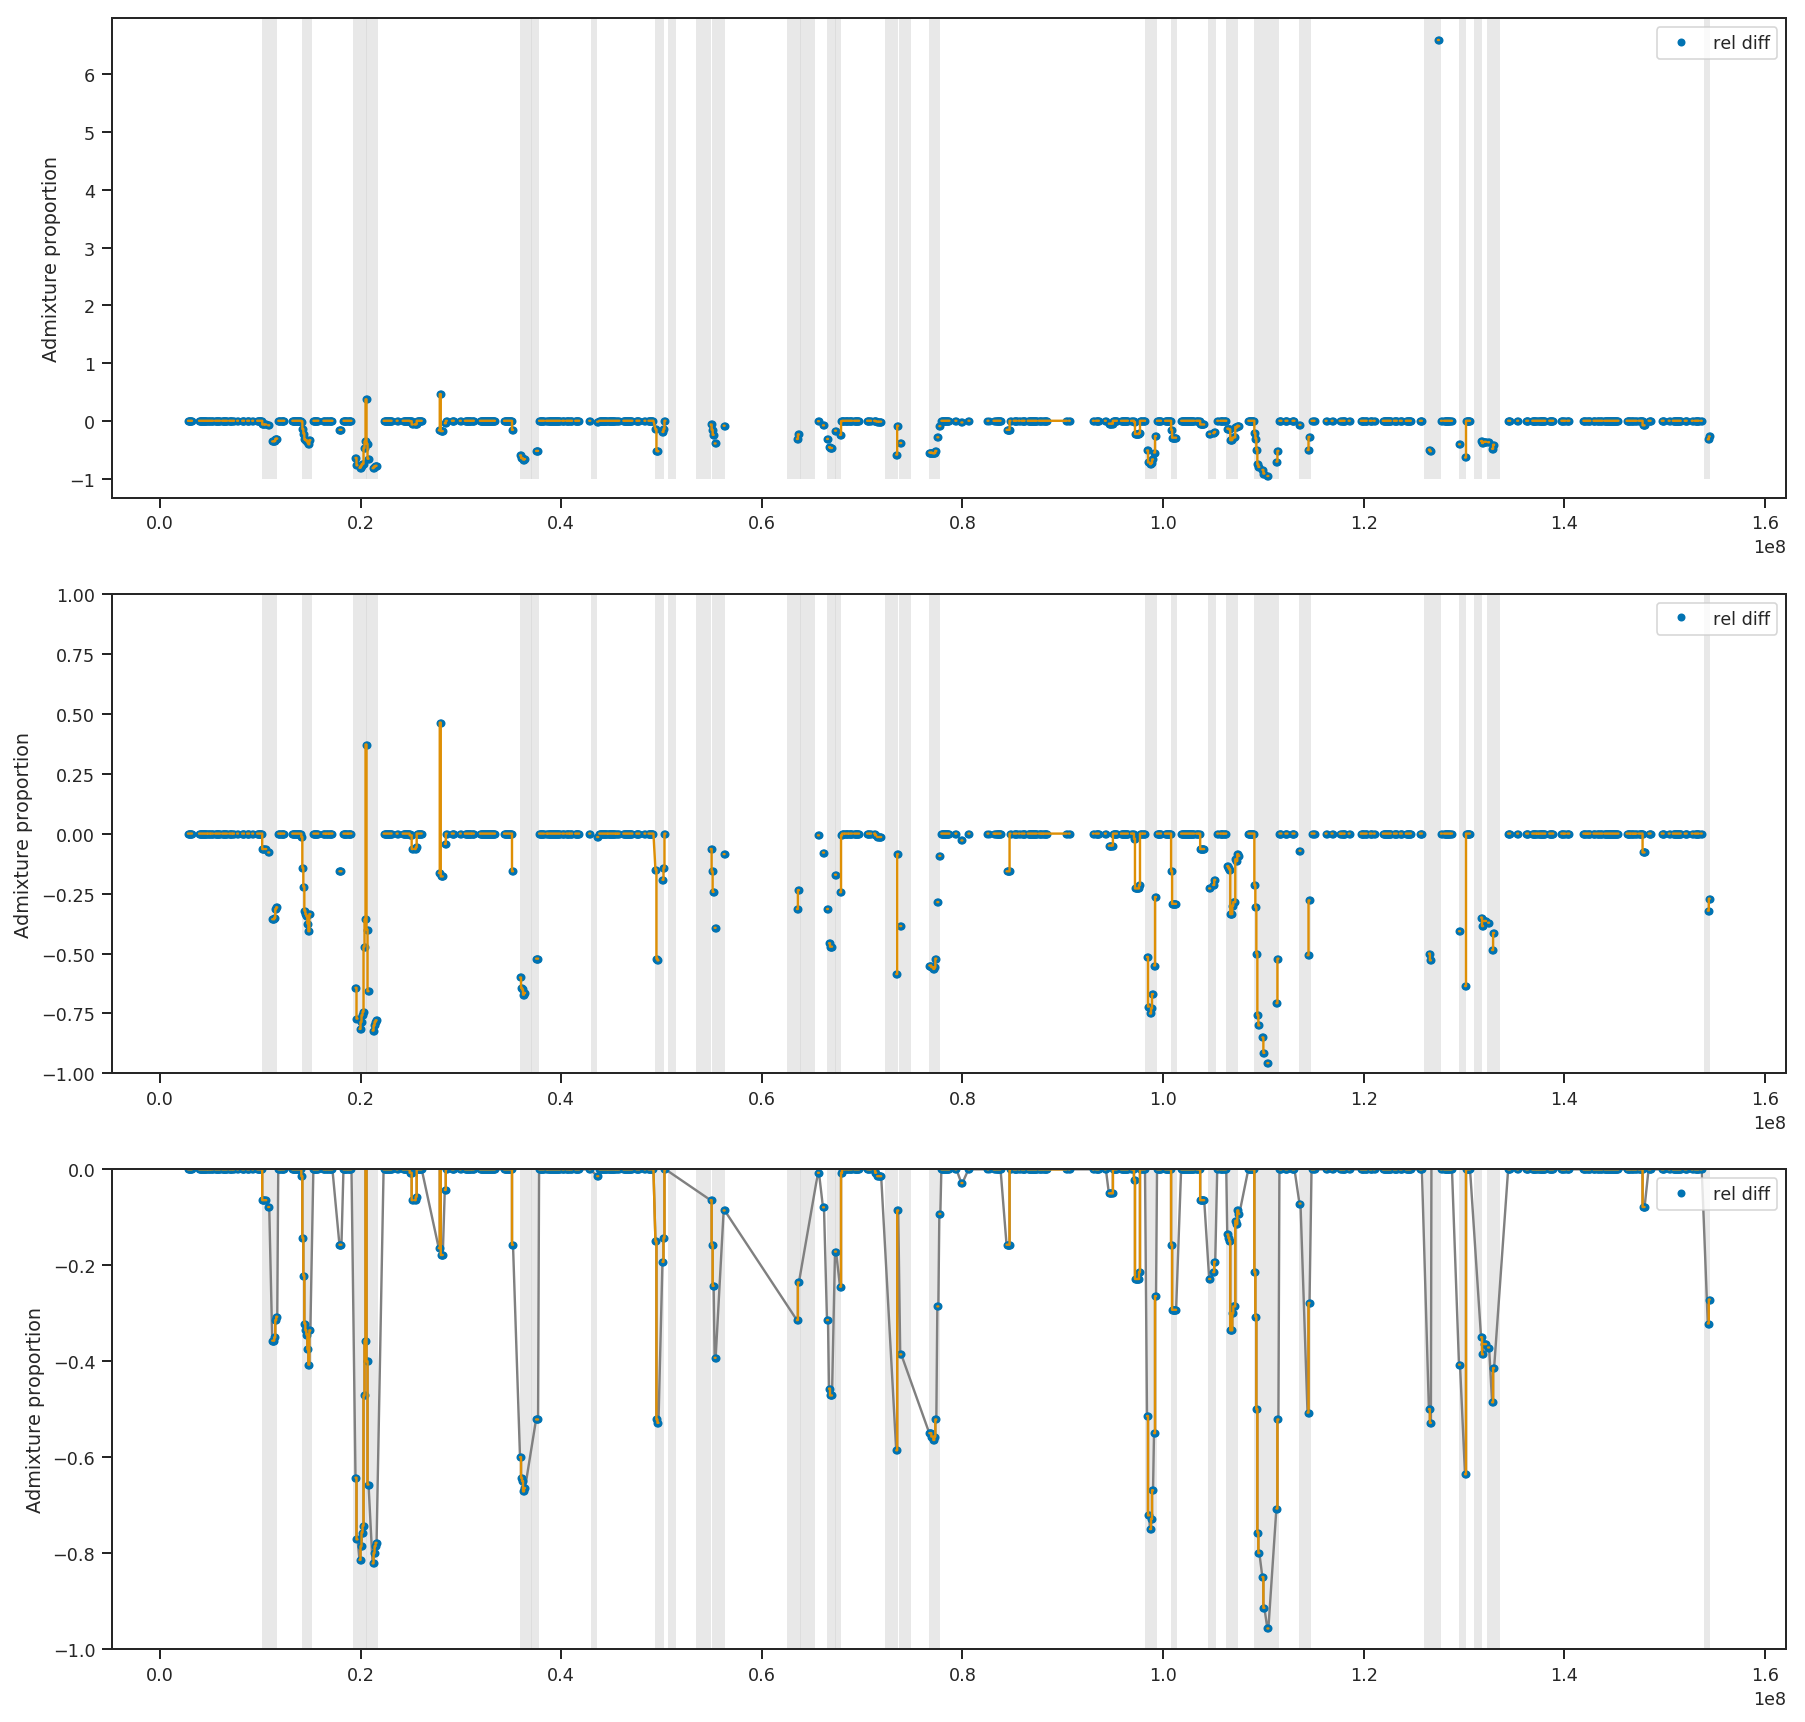

In [103]:
plot_df = stairs(win_means)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        y = -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
        
        ax1.plot(plot_df.pos, y, label='rel diff', marker='o', markersize=3, linestyle='none')
        ax1.plot(plot_df.pos, y)
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 8, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

        ax2.plot(plot_df.pos, y, label='rel diff', marker='o', markersize=3, linestyle='none')
        ax2.plot(plot_df.pos, y)
        ax2.legend(loc='upper right')
        ax2.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax2.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 8, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
        ax2.set_ylim(-1, 1)
        
        ax3.plot(plot_df.pos.loc[numpy.isfinite(y)], y.loc[numpy.isfinite(y)], color='grey')
        ax3.plot(plot_df.pos, y, 
                 label='rel diff', marker='o', markersize=3, linestyle='none')
        ax3.plot(plot_df.pos, y)


        ax3.legend(loc='upper right')
        ax3.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax3.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

#        sns.despine(trim=True)
        ax3.set_ylim(-1, 0)

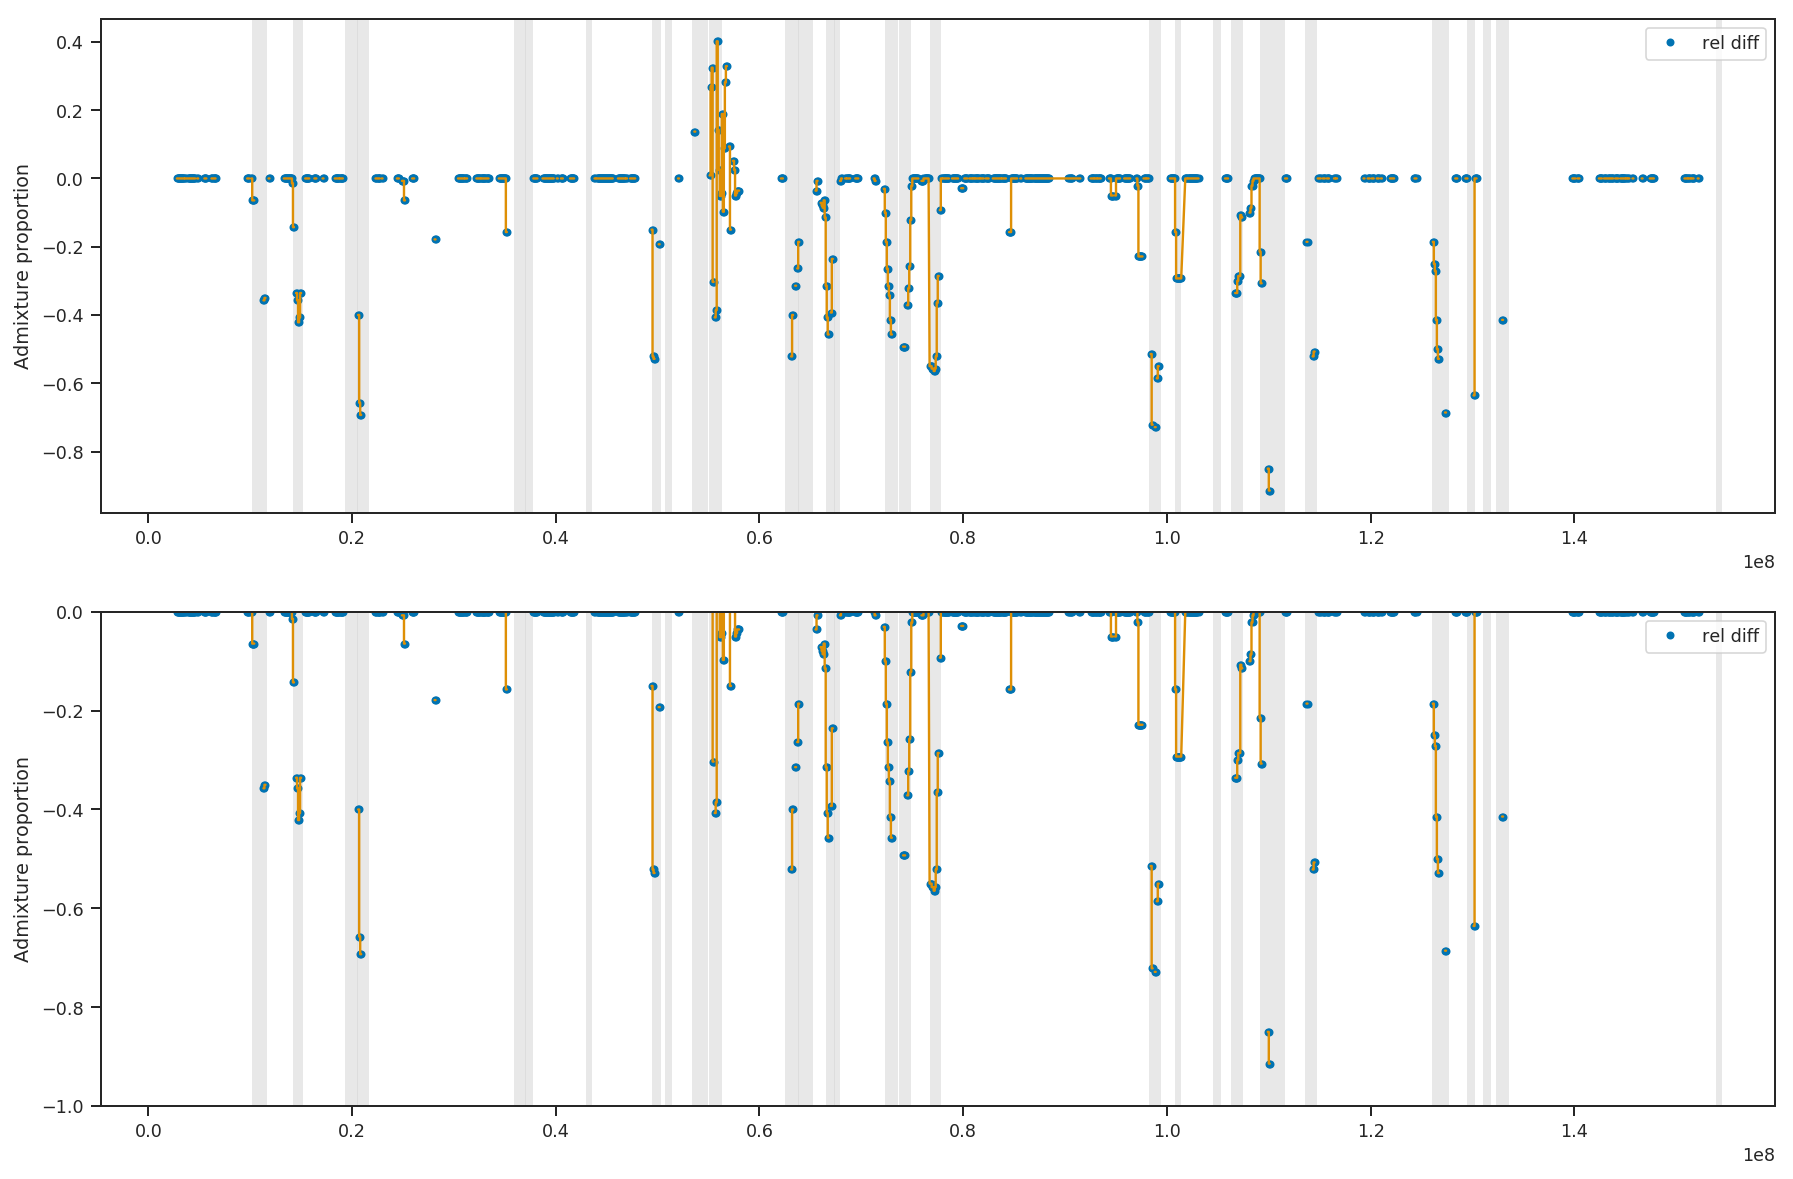

In [104]:
win_means_full = merged_data_full.loc[~merged_data_full.region_1.isin(['Africa']),
                    ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
win_means_full['admix_prop_not_sweept'] = merged_data_full.loc[(merged_data_full.swept == False) & ~merged_data_full.region_1.isin(['Africa']), 
                      ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
win_means_full['nr_swept'] = merged_data_full.loc[~merged_data_full.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.sum()
win_means_full['nr_total'] = merged_data_full.loc[~merged_data_full.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.size()
win_means_full['prop_swept'] = win_means_full.nr_swept / win_means_full.nr_total
win_means_full.reset_index(inplace=True)

win_means_full.head()

plot_df = stairs(win_means_full)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
        ax1.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept, 
                 label='rel diff', marker='o', markersize=3, linestyle='none')
        ax1.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept)
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

        ax2.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept, 
                 label='rel diff', marker='o', markersize=3, linestyle='none')
        ax2.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept)
        ax2.legend(loc='upper right')
        ax2.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax2.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

#        sns.despine(trim=True)
        ax2.set_ylim(-1, 0)

**NB: set plot_df back to analysis without repeats:**

In [59]:
plot_df = stairs(win_means)

In [60]:
# plot_df = merged_data.loc[~merged_data.region_1.isin(['Africa']),
#                     ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
# plot_df['admix_prop_not_sweept'] = merged_data.loc[(merged_data.swept == False) & ~merged_data.region_1.isin(['Africa']), 
#                       ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
# plot_df['nr_swept'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
#                       ['swept', 'start', 'end']].groupby(['start', 'end']).swept.sum()
# plot_df['nr_total'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
#                       ['swept', 'start', 'end']].groupby(['start', 'end']).swept.size()
# plot_df['prop_swept'] = plot_df.nr_swept / plot_df.nr_total
# plot_df.reset_index(inplace=True)
# #plot_df = stairs(plot_df)
# plot_df.head()

Admixture and ILS, ampl. regions and 10% regions:

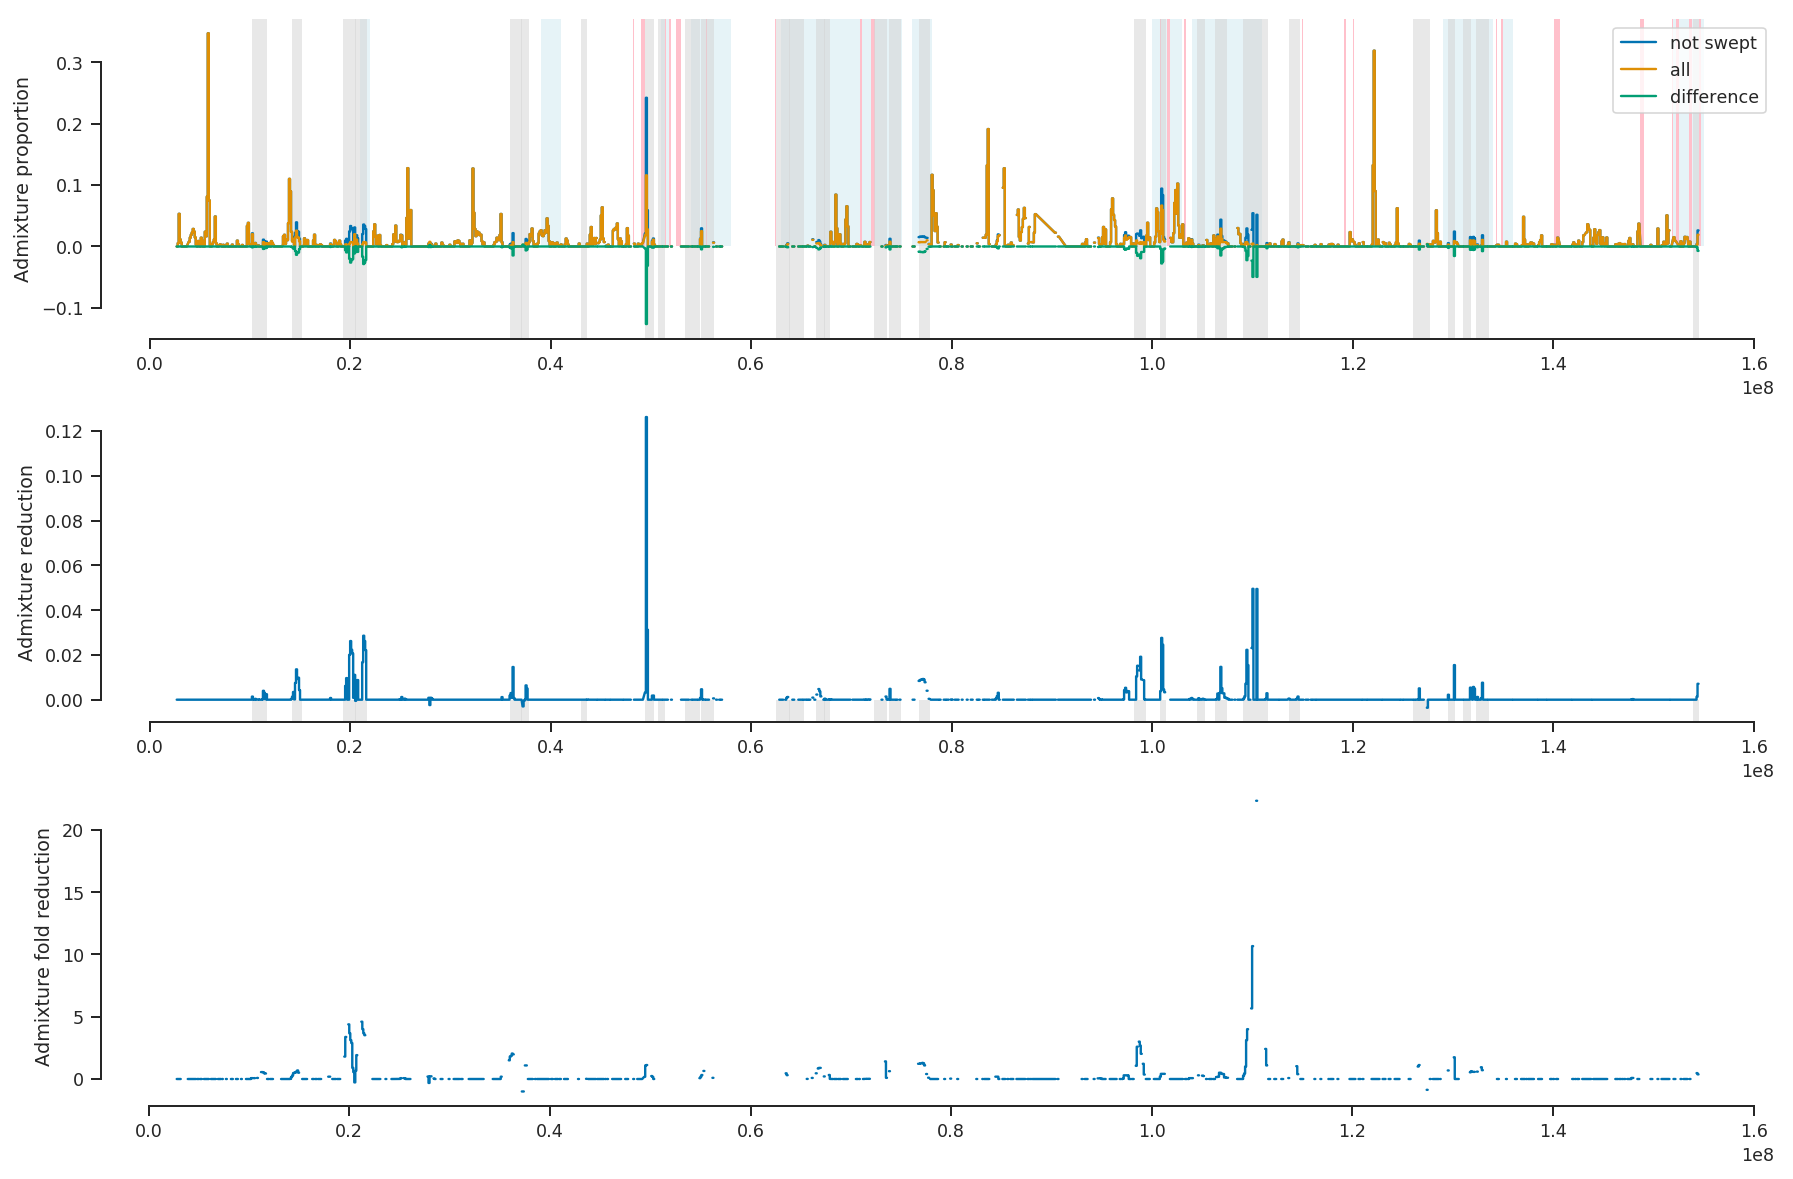

In [61]:
plot_df = stairs(win_means)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))
        ax1.plot(plot_df.pos, plot_df.admix_prop_not_sweept, label='not swept')
        ax1.plot(plot_df.pos, plot_df.admix_prop, label='all')
        ax1.plot(plot_df.pos, plot_df.admix_prop - plot_df.admix_prop_not_sweept, label='difference')
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')
        
        ax2.plot(plot_df.pos, plot_df.admix_prop_not_sweept - plot_df.admix_prop)
        ax2.set_ylabel('Admixture reduction')

        ax3.plot(plot_df.pos, (plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop)
        ax3.set_ylabel('Admixture fold reduction')

        for tup in extended_peak_regions_10.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
            g = ax2.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 1, 
                 facecolor='lightgray', 
                 linewidth=0,
        #              edgecolor=None,
                 alpha=0.5,
                 zorder=1))
            
        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='lightblue',
                         linewidth=0,
                         alpha=0.3,
                         zorder=0))
            
        for tup in ampliconic_regions.itertuples():
            g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='pink',
                         linewidth=0,
                         alpha=1,
                         zorder=0))            
            
            
        sns.despine(trim=True)
#mpld3.display() 

In [62]:
#mpld3.display(fig)        

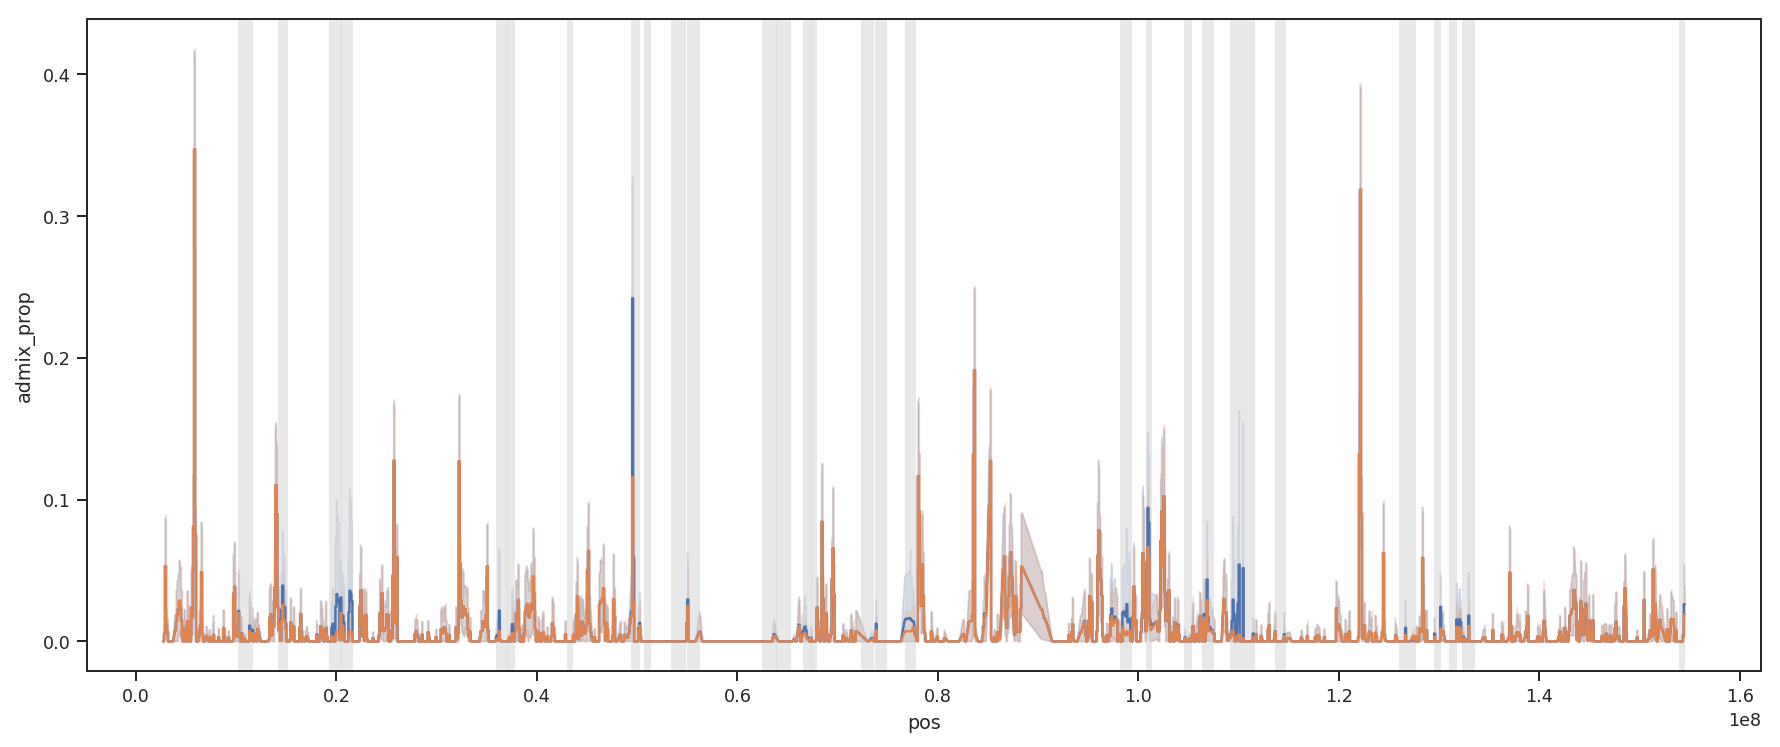

In [63]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))

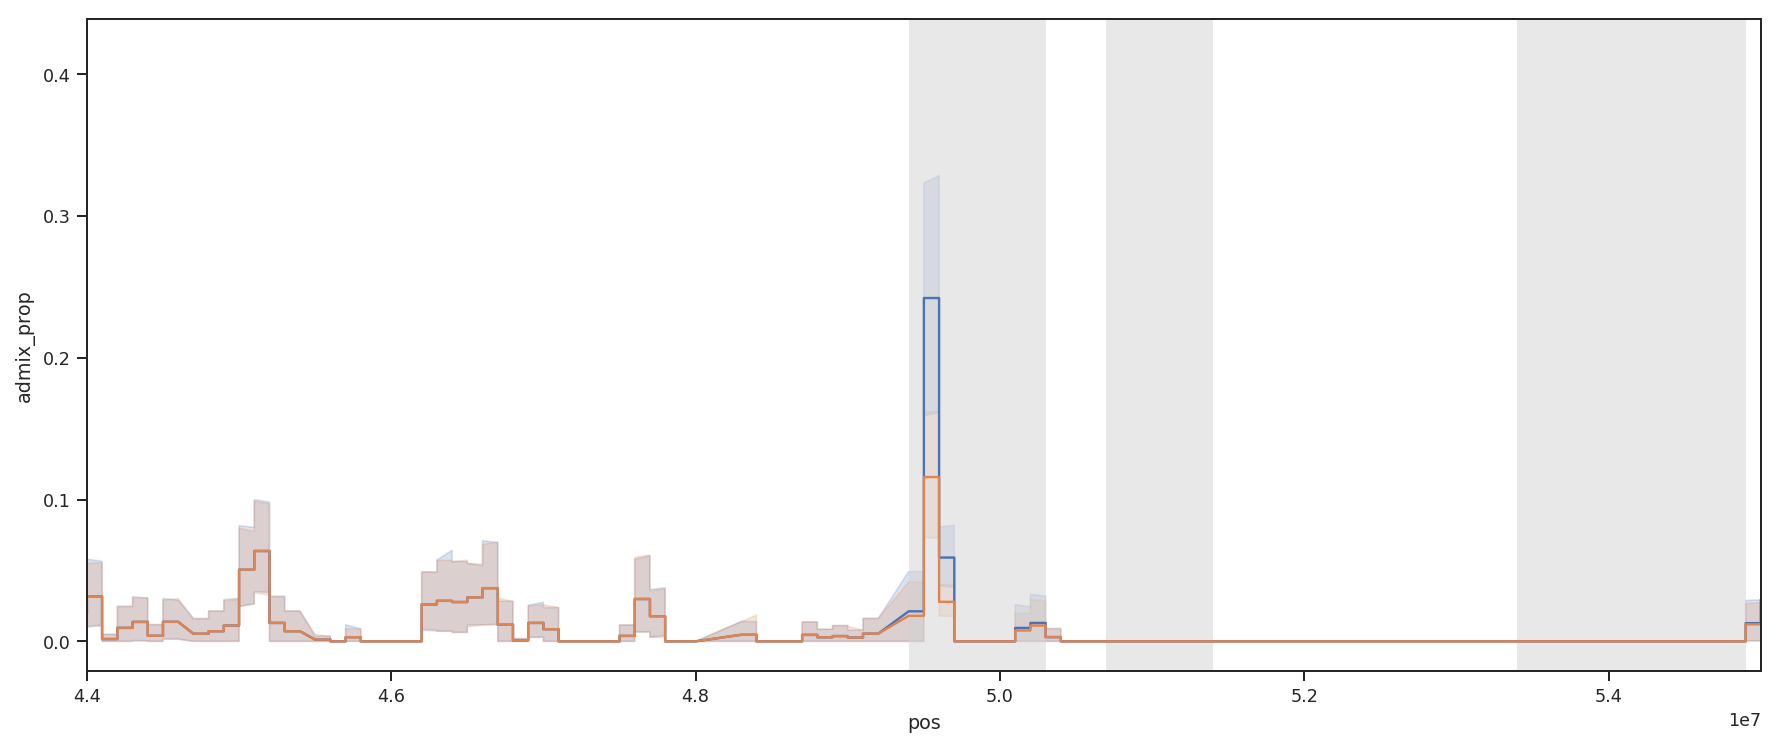

In [64]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))
    ax.set_xlim(44e6, 55e6)

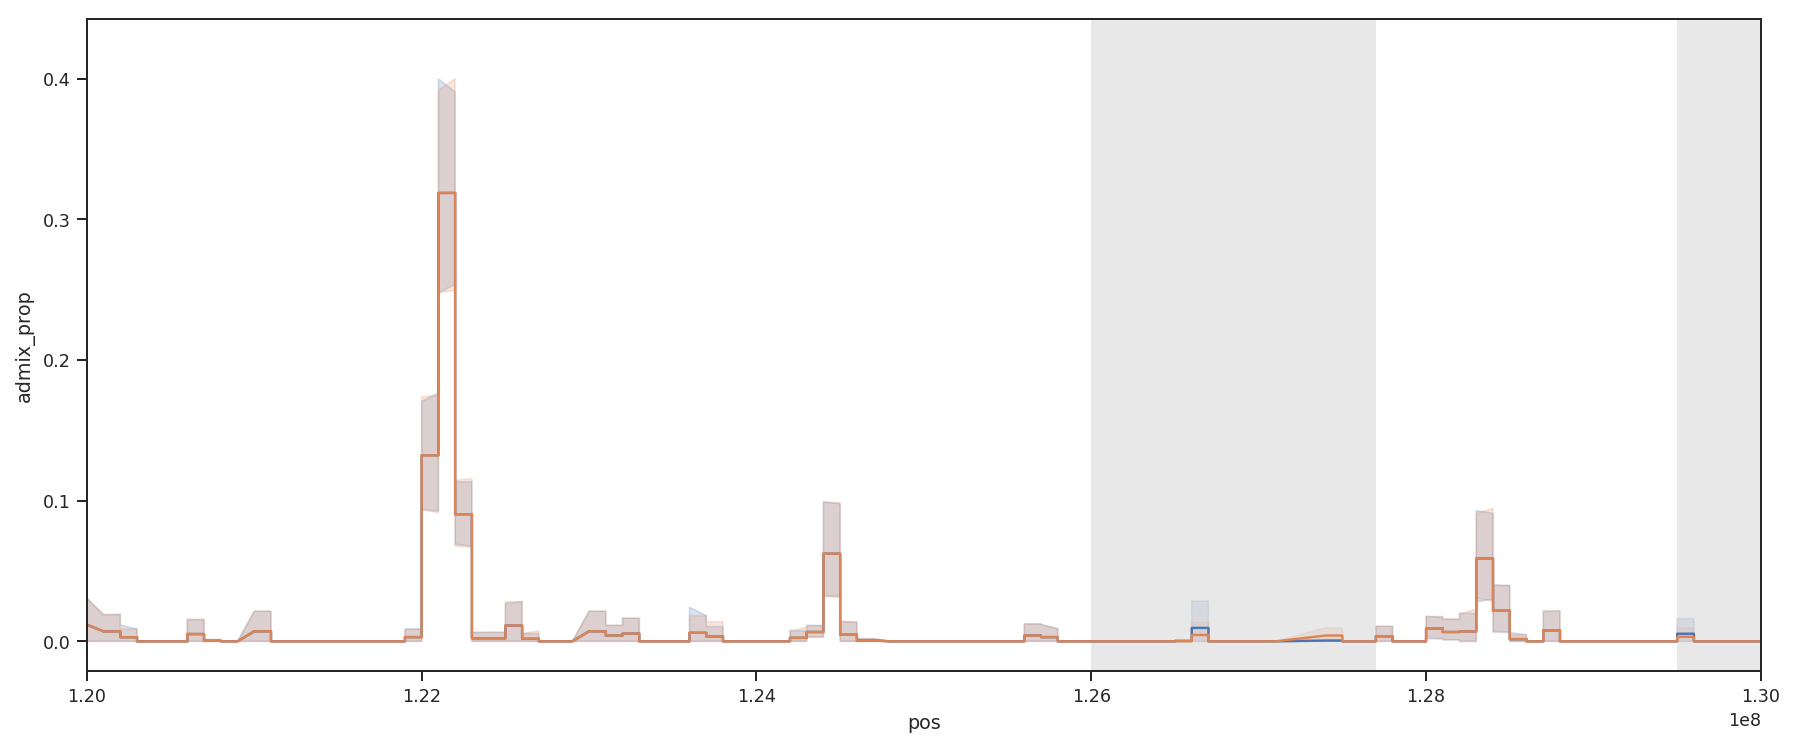

In [65]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))
    ax.set_xlim(120e6, 130e6)

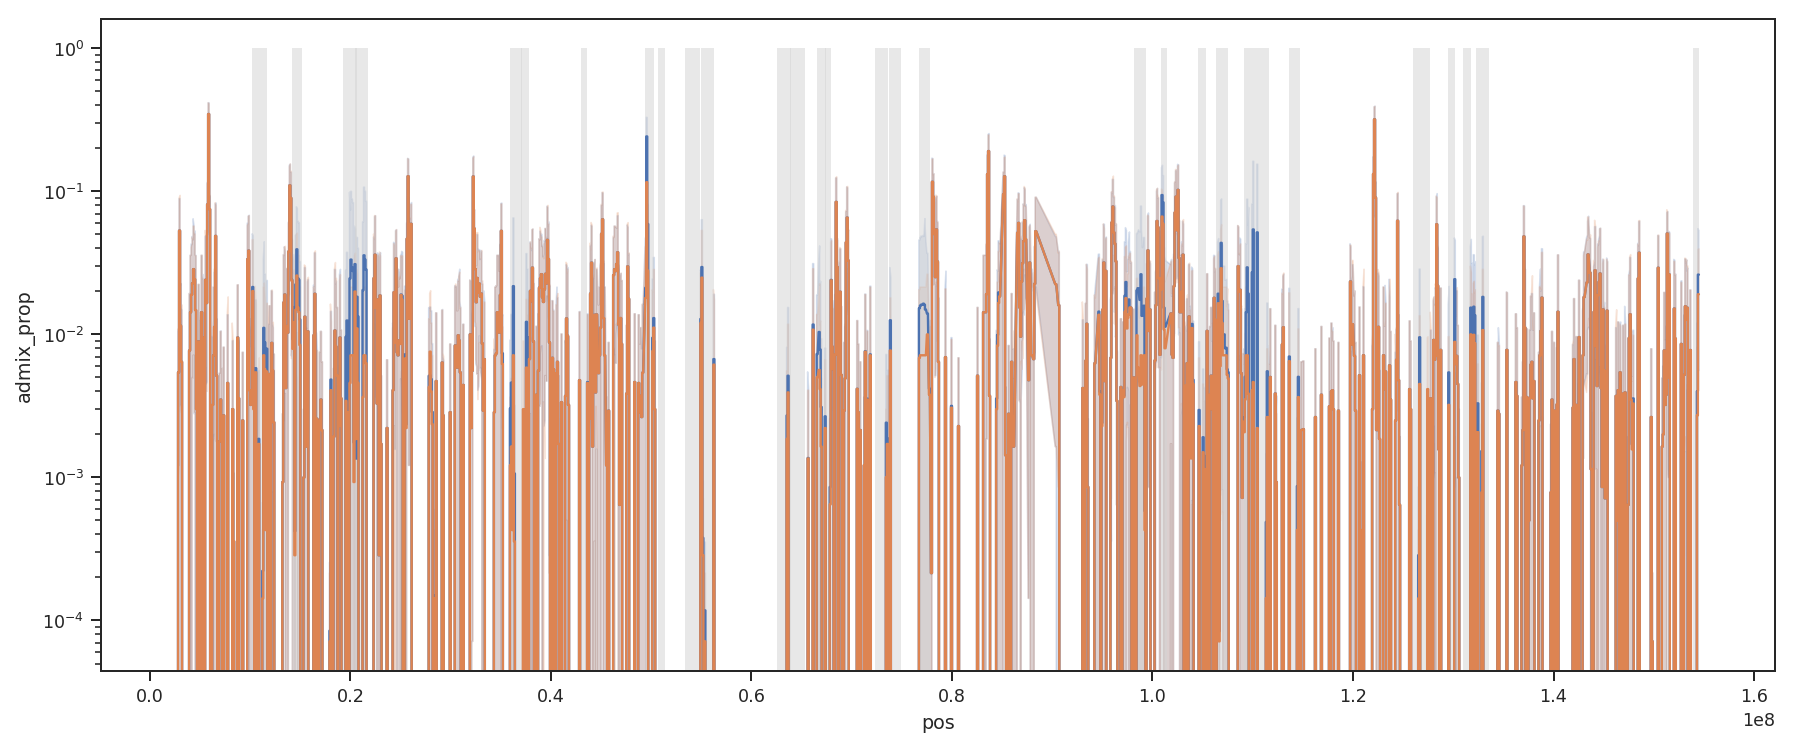

In [66]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))
    ax.set_yscale('log')

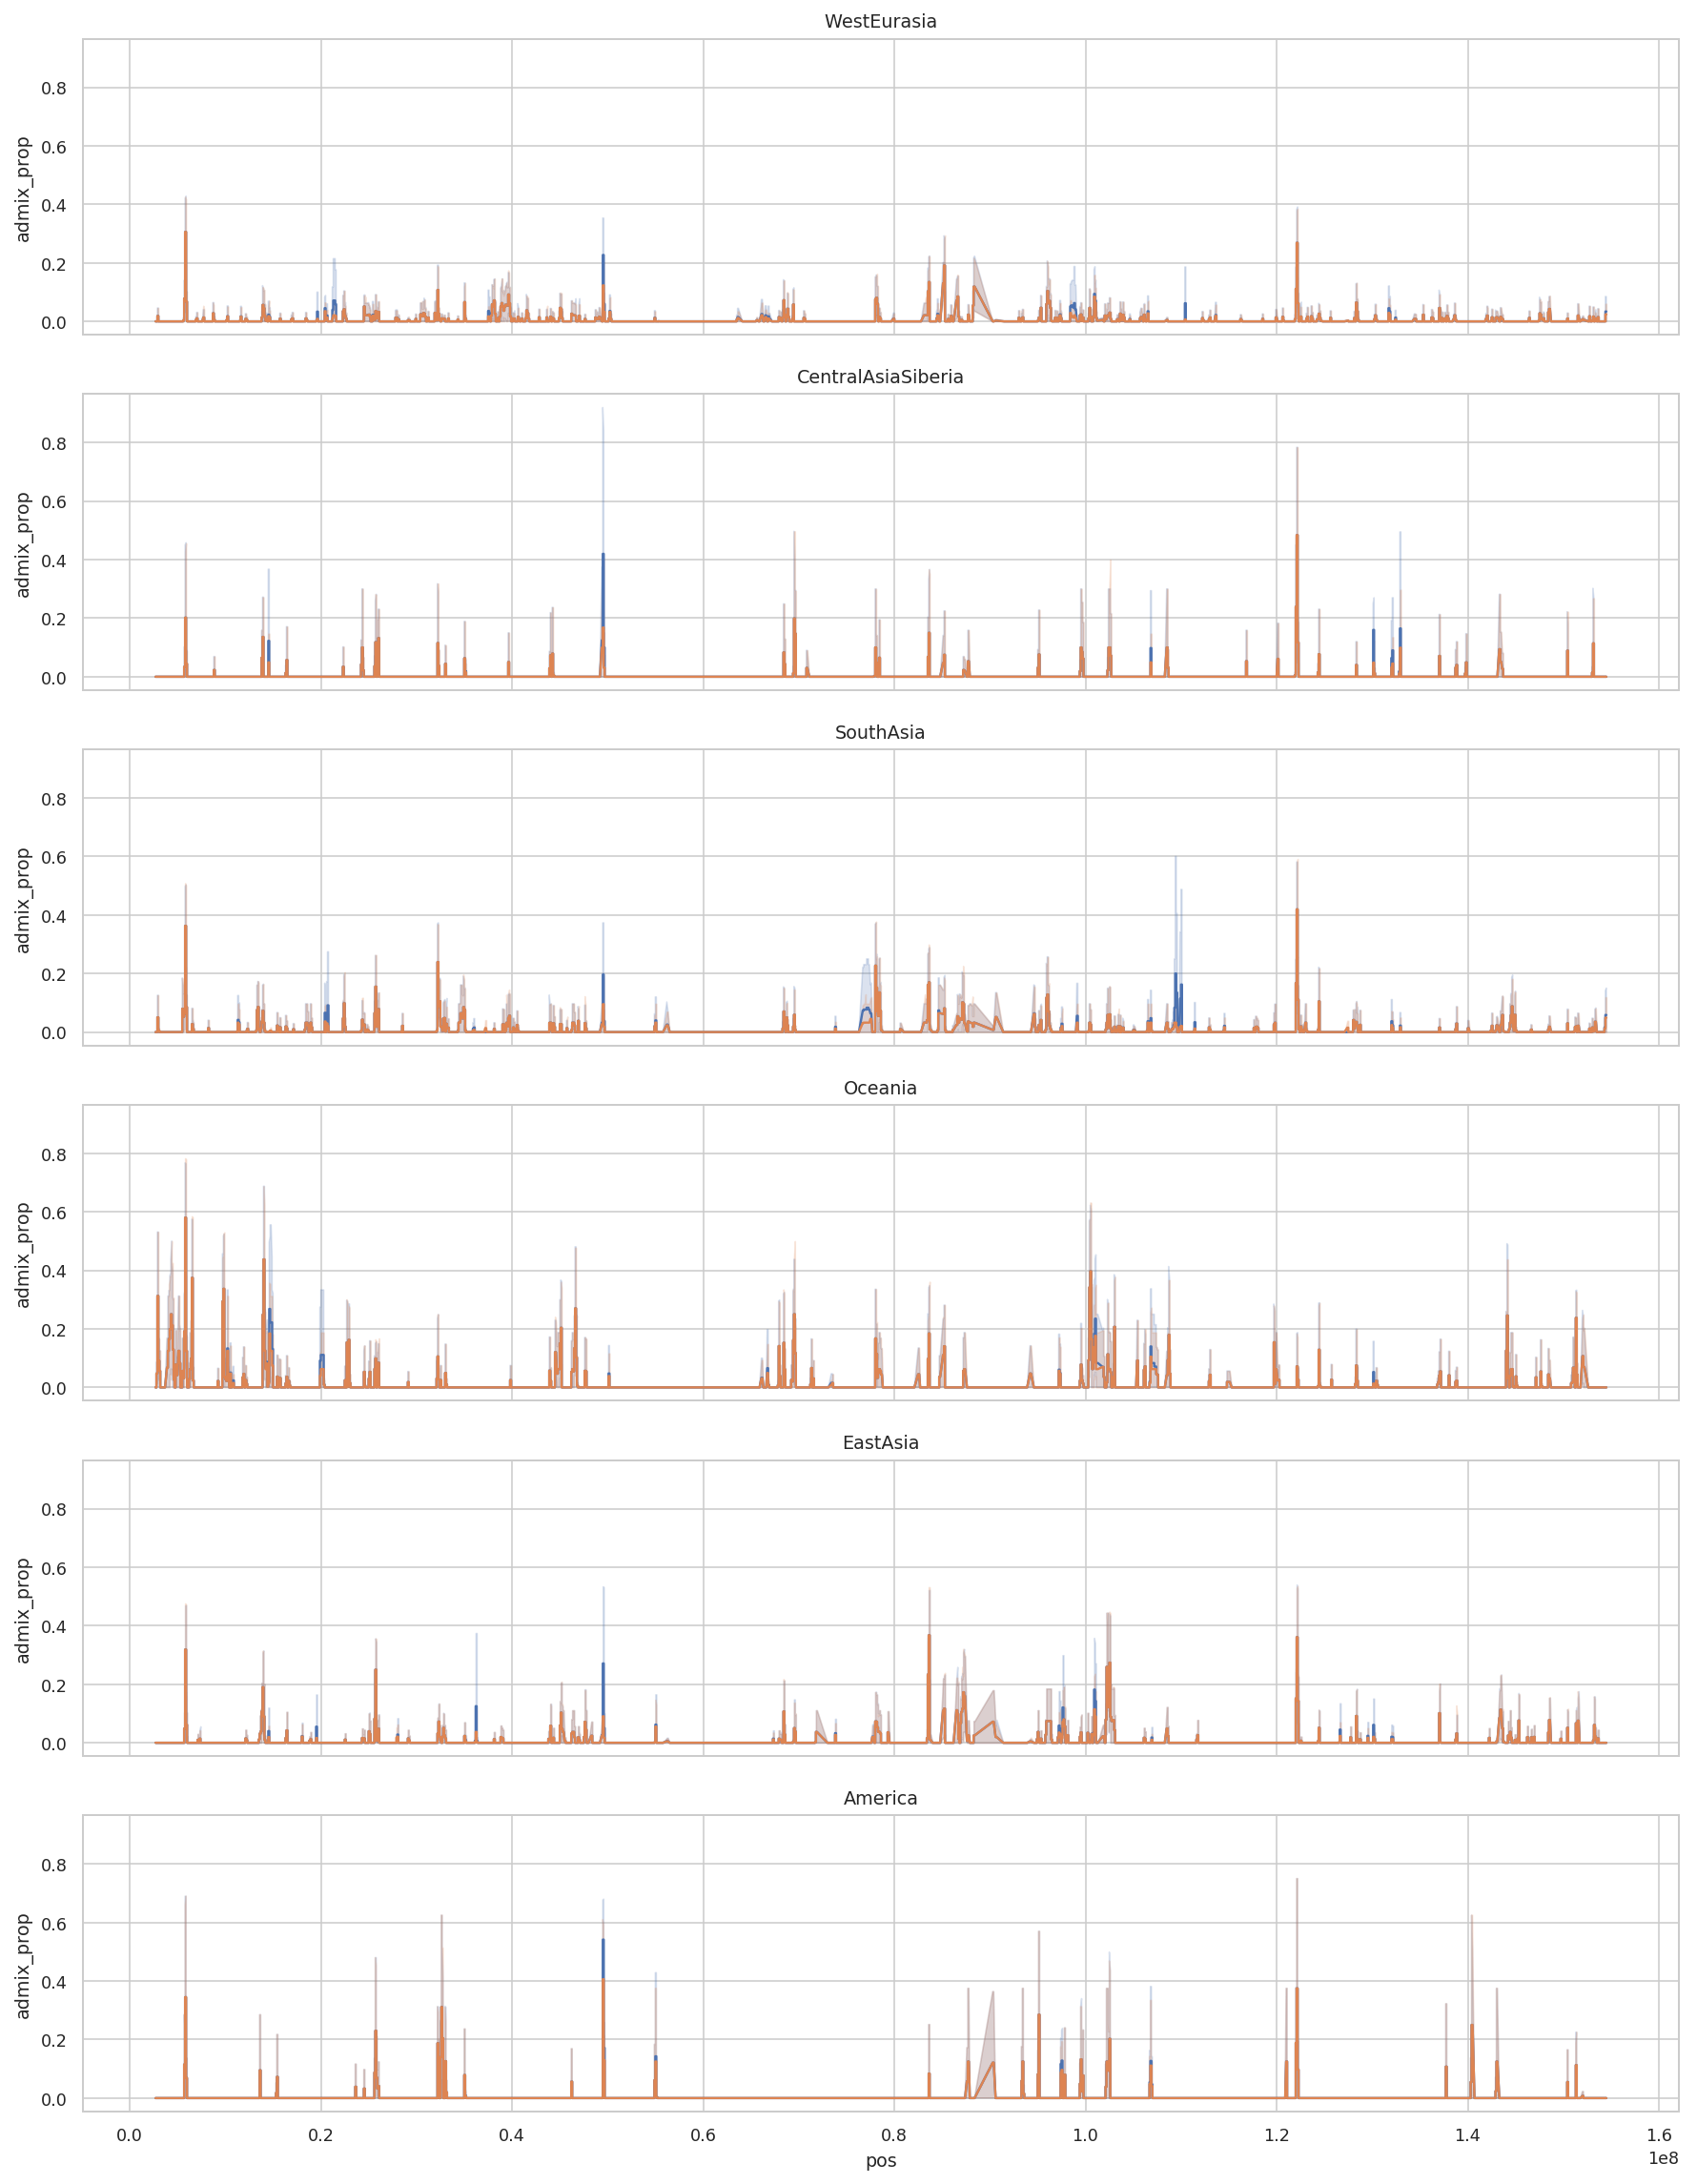

In [67]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.admix_prop, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.admix_prop, ax=axes[i])

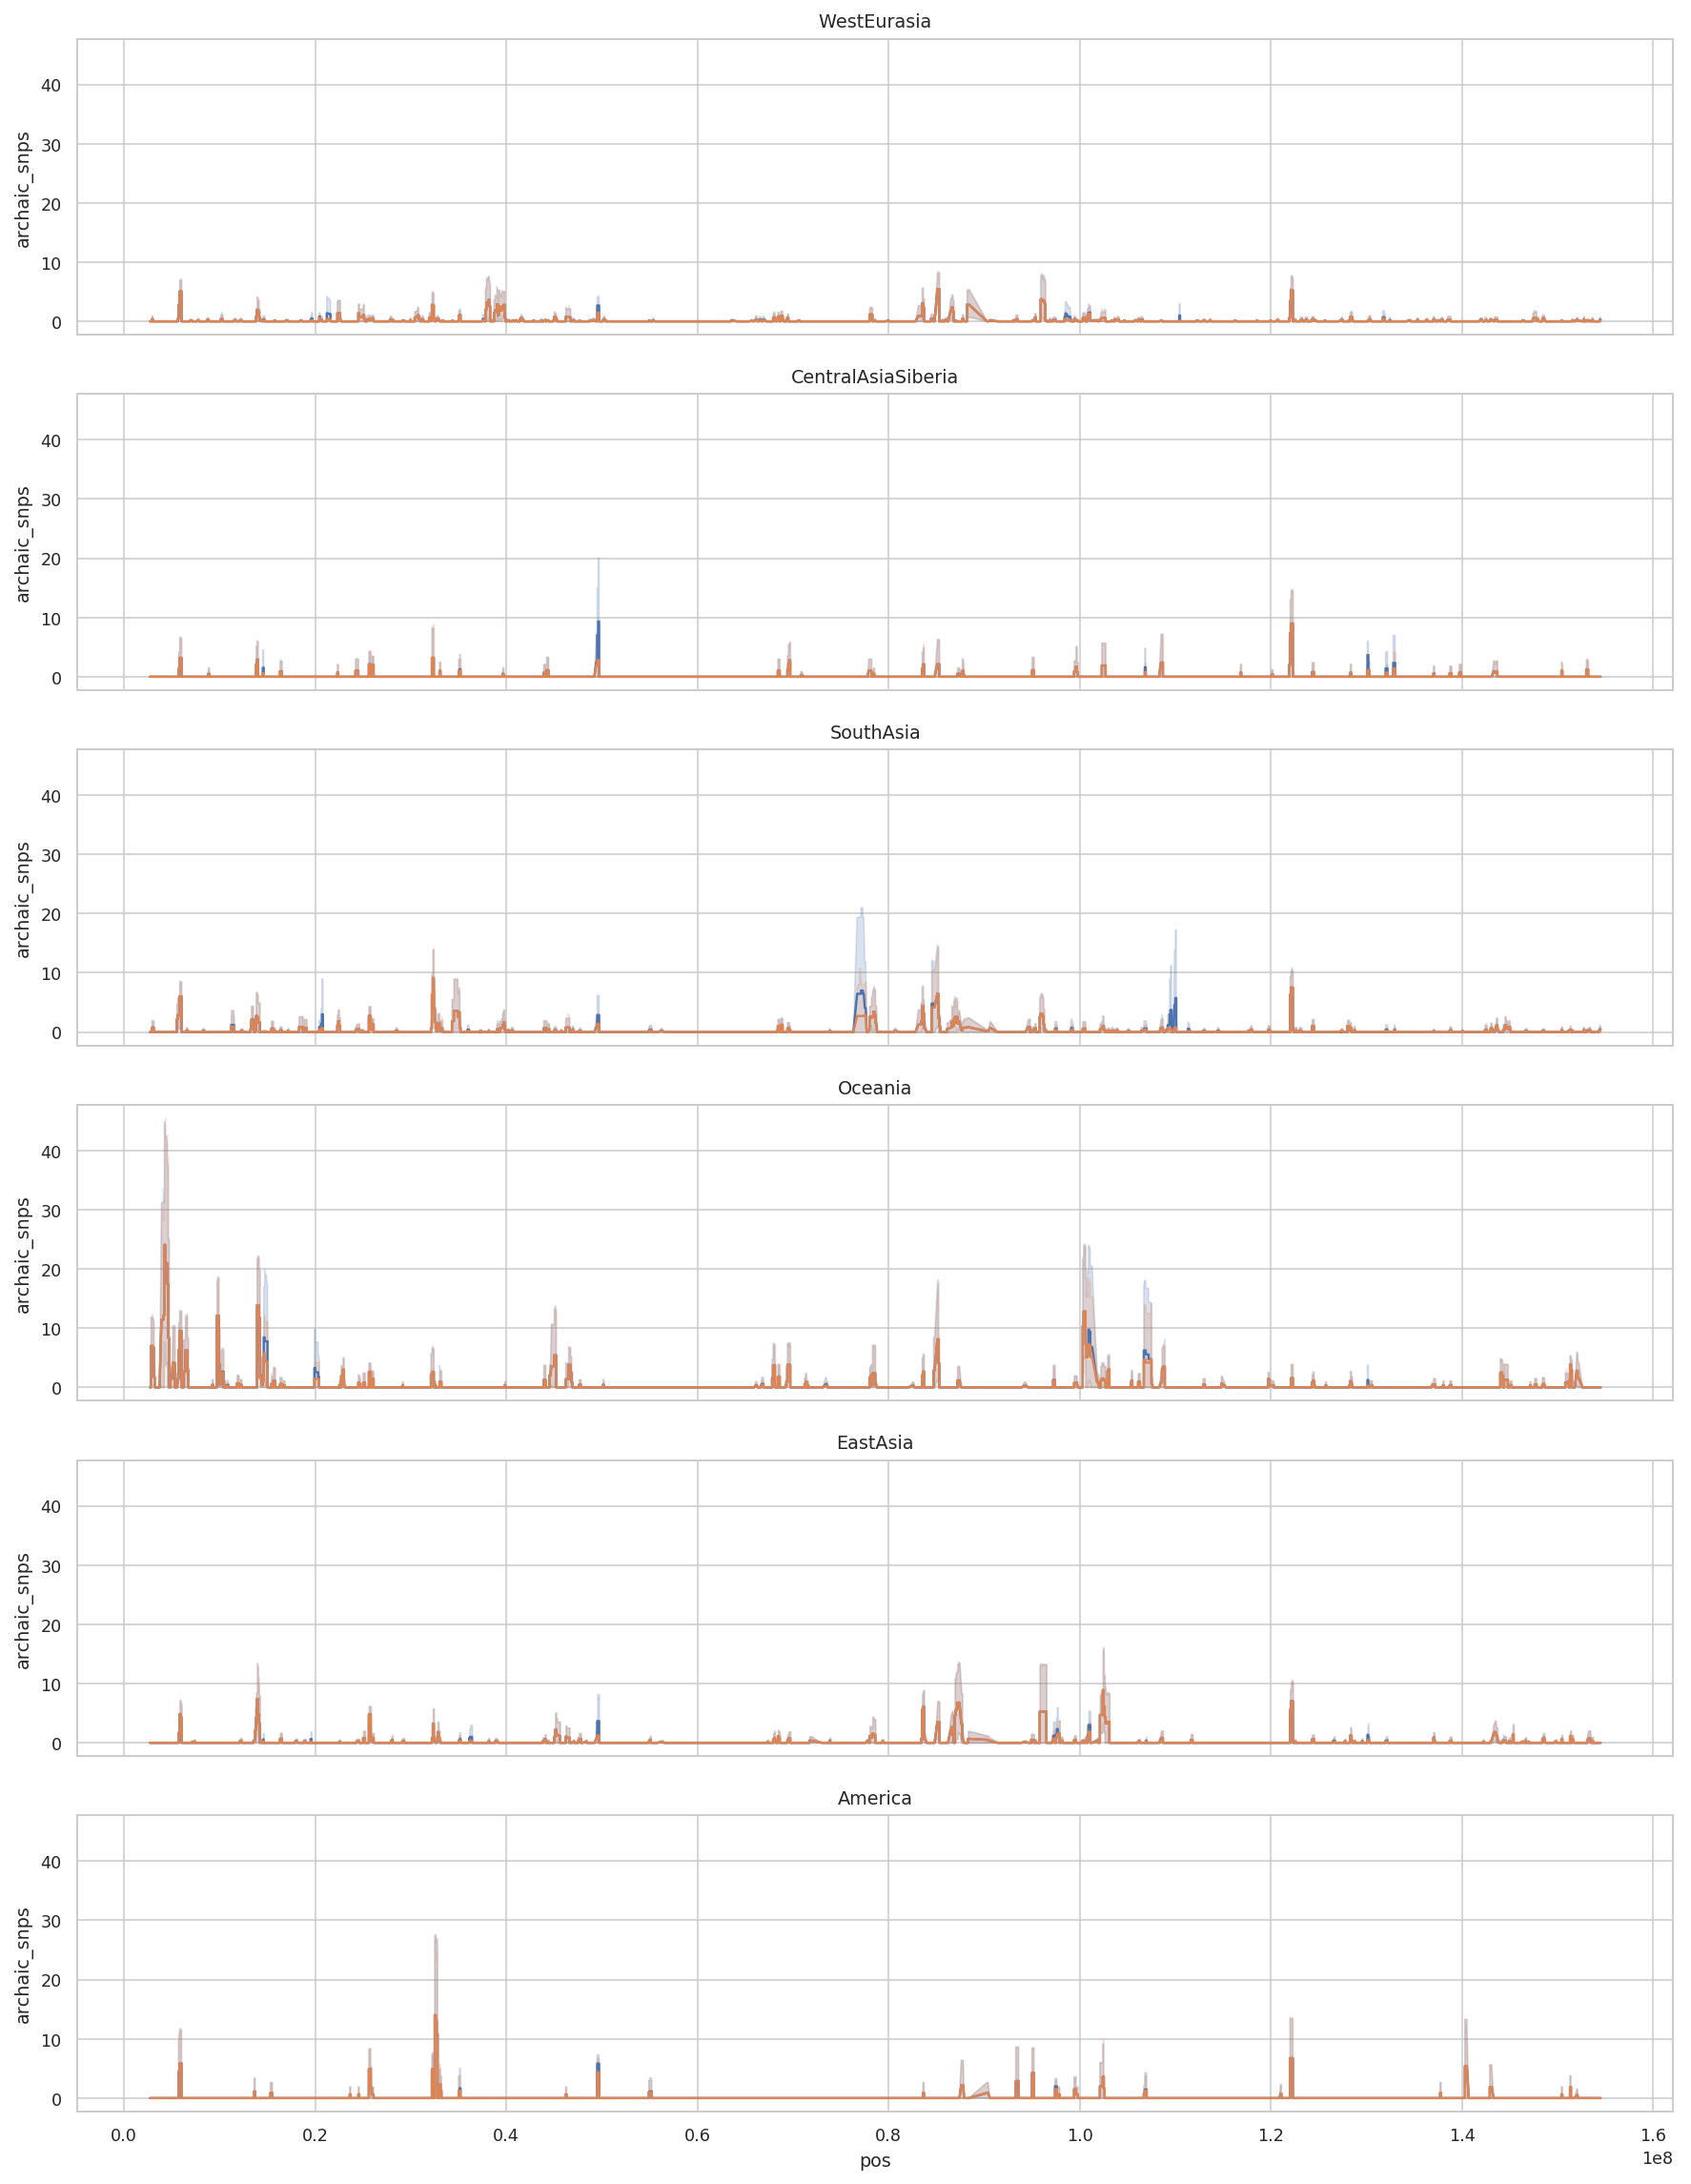

In [68]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.archaic_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.archaic_snps, ax=axes[i])

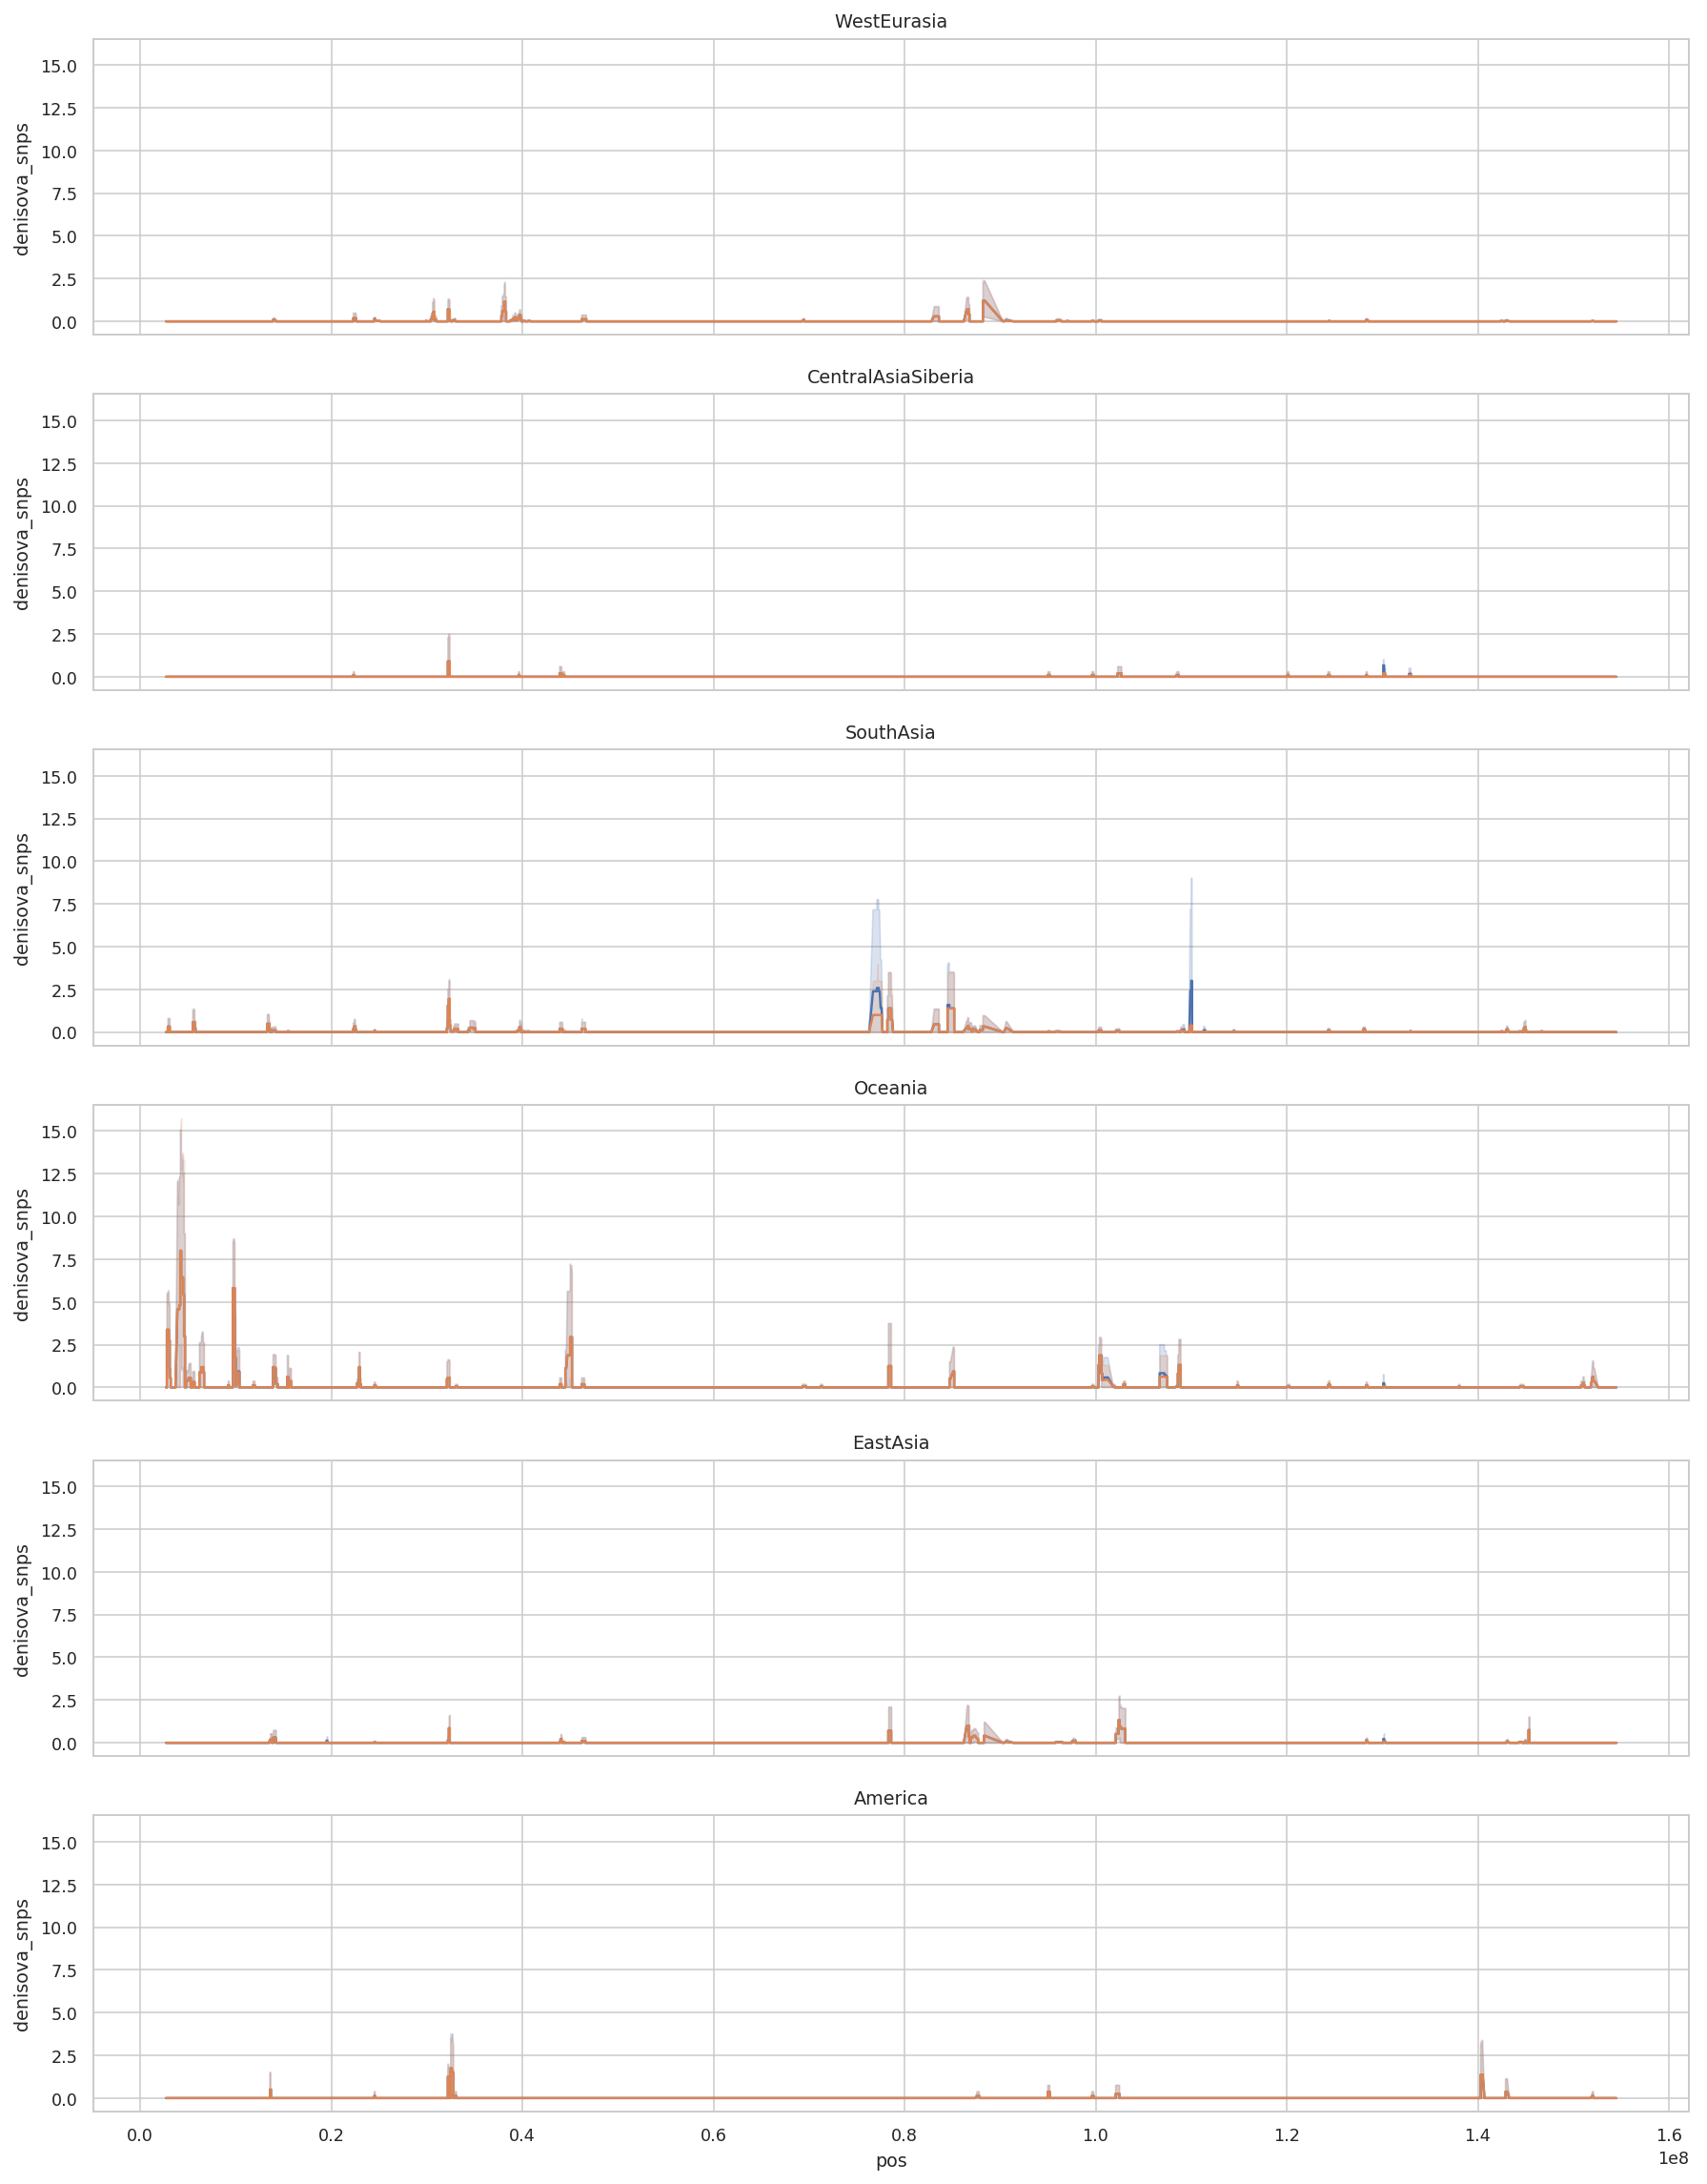

In [69]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.denisova_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.denisova_snps, ax=axes[i])

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.altai_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.altai_snps, ax=axes[i])

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.vindija_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.vindija_snps, ax=axes[i])

In [ ]:
# plt.figure(figsize=(20,5))
# #plt.plot(merged_data.start, merged_data.admix_prop)
# filtered = lowess(merged_data.admix_prop, merged_data.start, is_sorted=False, frac=0.001, it=0)
# plt.plot(filtered[:,0], filtered[:,1], color='orange')
# plt.show()